In [3]:
%matplotlib inline
import torchvision
import torch

In [ ]:
# ##

# class CNNCifar(nn.Module):
#     def __init__(self):
#         super(CNNCifar,self).__init__()
#         self.feature = nn.Sequential(
#             nn.Conv2d(3,64,3,padding=2),   nn.BatchNorm2d(64),  nn.ReLU(), nn.MaxPool2d(2,2),
#             nn.Conv2d(64,128,3,padding=2), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2,2),
#             nn.Conv2d(128,256,3,padding=1),nn.BatchNorm2d(256), nn.ReLU(), nn.MaxPool2d(2,2),
#             nn.Conv2d(256,512,3,padding=1),nn.BatchNorm2d(512), nn.ReLU(), nn.MaxPool2d(2,2)
#         )
#         self.classifier=nn.Sequential(
#             nn.Flatten(),
#             nn.Linear(2048, 4096),nn.ReLU(),nn.Dropout(0.5),
#             nn.Linear(4096,4096), nn.ReLU(),nn.Dropout(0.5),
#             nn.Linear(4096,50)
#         )
        
#     def forward(self, x):
 
#         x = self.feature(x)
#         output = self.classifier(x)
#         return output
        
# cnn = CNNCifar().to(device)
# print(cnn)

In [2]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import random_split
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchsampler import ImbalancedDatasetSampler
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from torch.utils.data import WeightedRandomSampler
import numpy as np
from torchvision.datasets import ImageFolder
import torch
from torchvision import transforms

In [73]:
!pip install https://github.com/ufoym/imbalanced-dataset-sampler/archive/master.zip

  Created wheel for torchsampler: filename=torchsampler-0.1.1-py3-none-any.whl size=3799 sha256=55bd5d1055db94b75ed257e31d93896cc1b4266a59c282b61cc45628b3076370
  Stored in directory: C:\Users\11380\AppData\Local\Temp\pip-ephem-wheel-cache-jqzquonv\wheels\90\7e\cd\4f5ece8831ffd9a54a62db046bca608f3a0a514dc47cba0eea
Successfully built torchsampler


In [1]:

import tensorflow as tf
print(tf.__version__)

1.15.0


In [9]:
!python D:\cifar-100-data\convert_from_tfrecords.py --input_path D:\cifar-100-data --cls_names_path D:\cifar-100-data\cifar100_clsname.json --output_path D:\cifar-100-data\cifar50\

done
Json has been saved to D:\cifar-100-data\cifar50\cifar50\cifar50_train.json
done
Json has been saved to D:\cifar-100-data\cifar50\cifar50_imbalance_0.1\cifar50_imbalance_0.1_train.json
done
Json has been saved to D:\cifar-100-data\cifar50\cifar50_imbalance_0.02\cifar50_imbalance_0.02_train.json
done
Json has been saved to D:\cifar-100-data\cifar50\cifar50_imbalance_0.005\cifar50_imbalance_0.005_train.json
done
Json has been saved to D:\cifar-100-data\cifar50\cifar50\cifar50_test.json
done
Json has been saved to D:\cifar-100-data\cifar50\cifar50_imbalance_0.1\cifar50_imbalance_0.1_test.json
done
Json has been saved to D:\cifar-100-data\cifar50\cifar50_imbalance_0.02\cifar50_imbalance_0.02_test.json
done
Json has been saved to D:\cifar-100-data\cifar50\cifar50_imbalance_0.005\cifar50_imbalance_0.005_test.json


2021-05-26 04:32:27.404107: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'cudart64_100.dll'; dlerror: cudart64_100.dll not found
2021-05-26 04:32:27.404148: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(string_tensor).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(input_tensor).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensors(tensor).repeat

In [5]:
torch.cuda.is_available()

True

Use CNN to train balanced dataset: cifar50_train.json

In [3]:
device = torch.device("cuda:0")
print(device)

cuda:0


In [17]:
# define a custom dataset
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset
import cv2
from PIL import Image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, transform=None, target_transform=None):
        self.img_labels = pd.read_json(annotations_file)
        #self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        # 0: img path, 1: img id, 2: img labels, 3: label name
        #img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        img_path = self.img_labels["annotations"][idx]["fpath"]
        image = cv2.imread(img_path)
        label = self.img_labels["annotations"][idx]["category_id"] / 2
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        sample = [image, label]
        #print(idx)
        return sample
    def get_label(self, idx):
        return self.__getitem__(idx)[1]
        
    def show_all(self):
        print(self.img_labels)
    def show_idx(self, i, j, k):
        print(self.img_labels[i][j][k])

def prepare_cnn(path=None):
    cnn = CNNCifar().to(device)
    if (path):
        cnn.load_state_dict(torch.load(path))
    criterion = nn.CrossEntropyLoss() 
    optimizer = optim.SGD(cnn.parameters(), lr=0.0001, momentum=0.9)
    return cnn, criterion, optimizer

In [5]:
def show_confusion_matrix(num_classes, confusion_matrix):
    fig, ax = plt.subplots()
    im = ax.imshow(confusion_matrix)

    # We want to show all ticks...
    ax.set_xticks(np.arange(50))
    ax.set_yticks(np.arange(50))
    # ... and label them with the respective list entries
    #ax.set_xticklabels()
    #ax.set_yticklabels()

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.

    for i in range(50):
        for j in range(50):
            text = ax.text(j, i, int(confusion_matrix[i][j].item()),
                           ha="center", va="center", color="w")



    ax.set_title("confusion matrix cifar50 long-tailed")
    fig.set_size_inches(20,20)
    fig.tight_layout()
    plt.show()
    

    
    
def train_cnn(save_folder, train_loader_c50, cifar50_train, start=1):
    n_epoch = 50
    accuracy_list = []
    loss_list = []
    PATH_PER_10EPOCH = "D:\cnn_models\\" + save_folder

    for epoch in range(n_epoch):  # loop over the dataset multiple times
      epoch_loss = 0.0
      running_loss = 0.0
      cnn.train()
      for i, data in enumerate(train_loader_c50):
        # TODO: write training code
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        #print(labels.to(device))
        #print("epoch:", epoch, "i:", i)
        # print("labels:", type(labels.to(device)))
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = cnn(inputs.float().to(device))
        loss = criterion(outputs, labels.to(device).long())
        loss.backward()
        optimizer.step()


        epoch_loss += outputs.shape[0] * loss.item()

        # print statistics
        #running_loss += loss.item()
        #if i % 2000 == 1999:    # print every 2000 mini-batches
         #   print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
          #  running_loss = 0.0

        # print epoch loss
      print(epoch+start, epoch_loss / len(cifar50_train))
      # (epoch+1) % 10 == 0
      if ((epoch+1) % 5 == 0):
        ## store state dict
        torch.save(cnn.state_dict(), PATH_PER_10EPOCH + '\cnn_cifar50' + '_EPO_' + str(epoch + start) + '.pth')
        loss_list.append(epoch_loss / len(train_loader_c50))

        # test accuracy
        total = 0
        correct = 0
        with torch.no_grad():
            cnn.eval()
            for data_test in test_loader_c50:
                images_test, labels_test = data_test[0].float().to(device), data_test[1].to(device).long()
                outputs_test = cnn(images_test)
                _, predicted = torch.max(outputs_test.data, 1)
                total += labels_test.size(0)
                correct += (predicted == labels_test).sum().item()

        print('Accuracy of test datasets: %d %%' % (
            100 * correct / total))
        # store accuracy
        accuracy_list.append(100 * correct / total)

    print('Finished Training')
    print(loss_list)
    print(accuracy_list)


In [6]:
class GaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
         
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [10]:
# data preparation
test_transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     ])

my_transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     transforms.RandomApply(torch.nn.ModuleList([transforms.RandomAffine(degrees=0, translate=(0.1, 0.1))]), p=0.3),
     transforms.RandomHorizontalFlip(p=0.3),
     transforms.RandomApply(torch.nn.ModuleList([transforms.RandomRotation(degrees=45)]), p=0.3),
     transforms.RandomApply(torch.nn.ModuleList([transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2)]), p=0.3)
    ])

cifar50_train = CustomImageDataset(annotations_file="D:\cifar-100-data\cifar50\cifar50\cifar50_train.json", transform=my_transform)
#cifar50_train_flip = CustomImageDataset(annotations_file="/content/gdrive/MyDrive/cifar50/cifar50/cifar50_train.json", transform=flip_transform)
#cifar50_train_rotate = CustomImageDataset(annotations_file="/content/gdrive/MyDrive/cifar50/cifar50/cifar50_train.json", transform=rotate_transform)
#cifar50_train_shift = CustomImageDataset(annotations_file="/content/gdrive/MyDrive/cifar50/cifar50/cifar50_train.json", transform=shift_transform)
#cifar50_train_noise = CustomImageDataset(annotations_file="/content/gdrive/MyDrive/cifar50/cifar50/cifar50_train.json", transform=noise_transform)

cifar50_test = CustomImageDataset(annotations_file="D:\cifar-100-data\cifar50\cifar50\cifar50_test.json", transform=test_transform)

#final_trainset = torch.utils.data.ConcatDataset([cifar50_train, cifar50_train_flip, cifar50_train_rotate,
                         #cifar50_train_shift, cifar50_train_noise])

print("Print the length of training dataset:\n ", len(cifar50_train))
print("Print the testing dataset:\n ", len(cifar50_test))
#print(len(cifar50_train))
#cifar50_train.show_idx("annotations", 0, "fpath")

train_loader_c50 = torch.utils.data.DataLoader(cifar50_train, batch_size=16, shuffle=True, drop_last=True)
test_loader_c50 = torch.utils.data.DataLoader(cifar50_test, batch_size=1, shuffle=False, drop_last=True)


Print the length of training dataset:
  25000
Print the testing dataset:
  5000


In [7]:
##

class CNNCifar(nn.Module):
    def __init__(self):
        super(CNNCifar,self).__init__()
        self.feature = nn.Sequential(
            nn.Conv2d(3,64,3,padding=2),   nn.BatchNorm2d(64),  nn.ReLU(), nn.MaxPool2d(2,2), # 16
            nn.Conv2d(64,128,3,padding=2), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2,2), # 8
            nn.Conv2d(128,256,3,padding=1),nn.BatchNorm2d(256), nn.ReLU(), nn.MaxPool2d(2,2), # 4
            nn.Conv2d(256,512,3,padding=1),nn.BatchNorm2d(512), nn.ReLU(), nn.MaxPool2d(2,2), # 2
            nn.Conv2d(512,1024,3,padding=1),nn.BatchNorm2d(1024), nn.ReLU() # 2
        )
        self.classifier=nn.Sequential(
            nn.Flatten(),
            nn.Linear(4096, 8192),nn.ReLU(),nn.Dropout(0.5),
            nn.Linear(8192,8192), nn.ReLU(),nn.Dropout(0.5),
            nn.Linear(8192,50)
        )
        
    def forward(self, x):
 
        x = self.feature(x)
        output = self.classifier(x)
        return output
        
cnn = CNNCifar().to(device)
print(cnn)

CNNCifar(
  (feature): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True

In [23]:
cnn = ResNet152(50).to(device)

In [9]:
import torch.optim as optim

# TODO: you can change loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn.parameters(), lr=0.0001, momentum=0.9)

In [50]:
n_epoch = 50
accuracy_list = []
loss_list = []
PATH_PER_10EPOCH = "D:\cnn_models\cifar50_8192"

for epoch in range(n_epoch):  # loop over the dataset multiple times
  epoch_loss = 0.0
  running_loss = 0.0
  cnn.train()
  for i, data in enumerate(train_loader_c50):
    # TODO: write training code
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    #print(labels.to(device))
    #print("epoch:", epoch, "i:", i)
    # print("labels:", type(labels.to(device)))
    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = cnn(inputs.float().to(device))
    loss = criterion(outputs, labels.to(device).long())
    loss.backward()
    optimizer.step()
    

    epoch_loss += outputs.shape[0] * loss.item()

    # print statistics
    #running_loss += loss.item()
    #if i % 2000 == 1999:    # print every 2000 mini-batches
     #   print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
      #  running_loss = 0.0

    # print epoch loss
  print(epoch+1, epoch_loss / len(cifar50_train))
  # (epoch+1) % 10 == 0
  if ((epoch+1) % 5 == 0):
    ## store state dict
    torch.save(cnn.state_dict(), PATH_PER_10EPOCH + '\cnn_cifar50' + '_EPO_' + str(epoch + 1) + '.pth')
    loss_list.append(epoch_loss / len(train_loader_c50))
    
    # test accuracy
    total = 0
    correct = 0
    with torch.no_grad():
        cnn.eval()
        for data_test in test_loader_c50:
            images_test, labels_test = data_test[0].float().to(device), data_test[1].to(device).long()
            outputs_test = cnn(images_test)
            _, predicted = torch.max(outputs_test.data, 1)
            total += labels_test.size(0)
            correct += (predicted == labels_test).sum().item()

    print('Accuracy of test datasets: %d %%' % (
        100 * correct / total))
    # store accuracy
    accuracy_list.append(100 * correct / total)

print('Finished Training')
print(loss_list)
print(accuracy_list)
#PATH = '/content/gdrive/MyDrive/EE 443/cnn_cifar50.pth'
#torch.save(cnn.state_dict(), PATH)

1 3.8159640719604493
2 3.530663328704834
3 3.2863801943969726
4 3.1058089489746092
5 2.9526864116668703
Accuracy of test datasets: 30 %
6 2.8378434107971193
7 2.7422871977233885
8 2.658772050933838
9 2.5815867597961426
10 2.5106715781402587
Accuracy of test datasets: 41 %
11 2.449114368209839
12 2.3773007999420166
13 2.305868714141846
14 2.2560945655822753
15 2.225482545928955
Accuracy of test datasets: 49 %
16 2.1683337744140627
17 2.117825990791321
18 2.0696875304412843
19 2.0526697394561766
20 2.0123293897247314
Accuracy of test datasets: 53 %
21 1.9779552965545655
22 1.9352033475112915
23 1.9030519846725464
24 1.8761594860076904
25 1.848841471862793
Accuracy of test datasets: 55 %
26 1.8163718440246581
27 1.7790722079467773
28 1.7482419728088379
29 1.7336808282661438
30 1.7059679078674317
Accuracy of test datasets: 57 %
31 1.6905998054504394
32 1.6609383587646485
33 1.625502190284729
34 1.6152062656021118
35 1.5864296506500244
Accuracy of test datasets: 58 %
36 1.556960484085083
37

In [51]:
from sklearn.metrics import f1_score
# accuracy for each class
nb_classes = 50
cnn = CNNCifar().to(device)
cnn.load_state_dict(torch.load('D:\cnn_models\cifar50_8192\cnn_cifar50_EPO_50.pth'))
confusion_matrix = torch.zeros(nb_classes, nb_classes)
y_preds = []
y_true = []
with torch.no_grad():
    cnn.eval()
    for data in test_loader_c50:
        inputs, classes = data[0].float().to(device), data[1].to(device).long()
        outputs = cnn(inputs)
        _, preds = torch.max(outputs, 1)
        y_preds.append(preds.item())
        y_true.append(classes.item())
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix.diag()/confusion_matrix.sum(1))

f1 = f1_score(y_true, y_preds, average='macro')
print("f1 score =", f1)

tensor([0.9000, 0.3500, 0.4400, 0.5300, 0.8100, 0.5400, 0.8200, 0.3800, 0.7200,
        0.5100, 0.8900, 0.5500, 0.7800, 0.5900, 0.7700, 0.8500, 0.4500, 0.6900,
        0.7100, 0.5700, 0.5000, 0.6300, 0.4400, 0.3400, 0.8200, 0.4200, 0.8400,
        0.6600, 0.7600, 0.7900, 0.8800, 0.5800, 0.3400, 0.6700, 0.8700, 0.6500,
        0.3900, 0.3800, 0.8100, 0.4400, 0.4400, 0.7700, 0.6000, 0.6600, 0.5800,
        0.6800, 0.4500, 0.8800, 0.6100, 0.4500])
f1 score = 0.6208860412413659


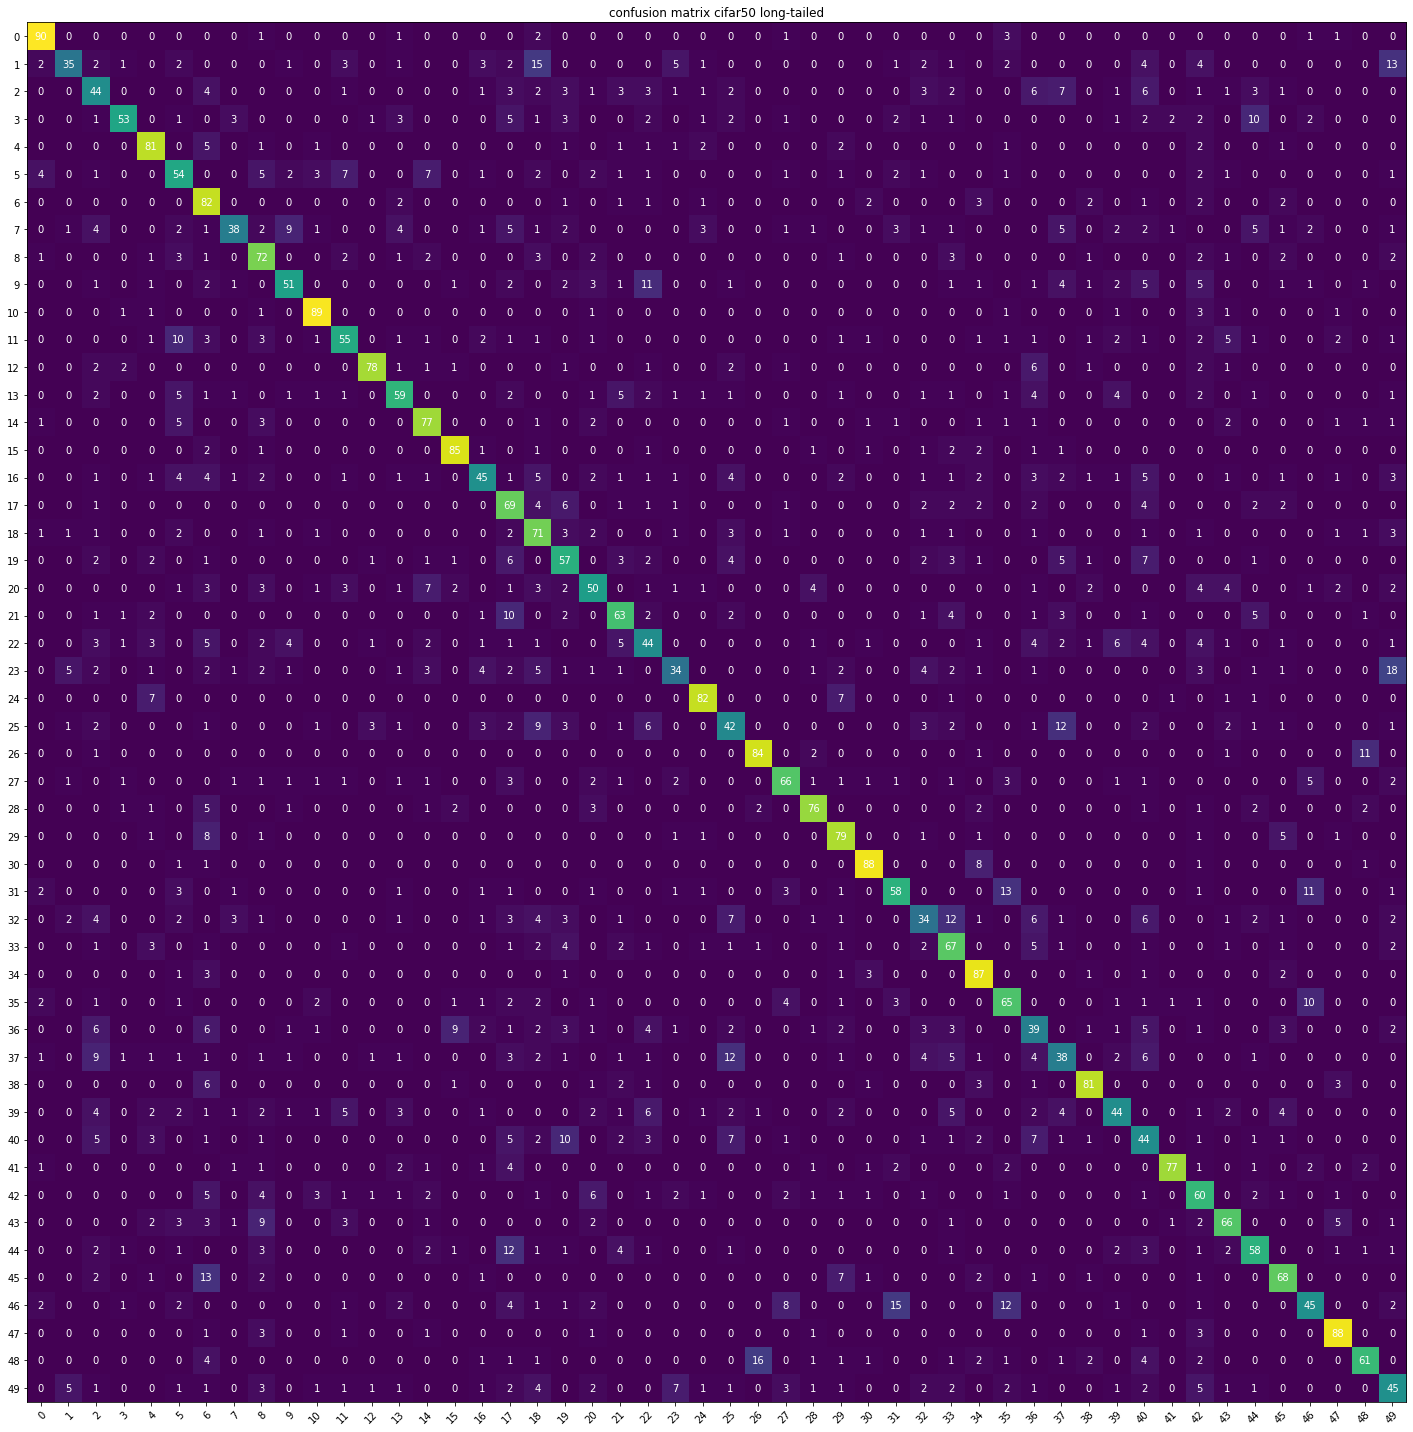

In [52]:
show_confusion_matrix(50, confusion_matrix)

In [18]:
# TODO: you can change loss function and optimizer
cnn = CNNCifar().to(device)
cnn.load_state_dict(torch.load('D:\cnn_models\cifar50_8192\cnn_cifar50_EPO_50.pth'))
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn.parameters(), lr=0.0001, momentum=0.9)

In [19]:
n_epoch = 50
accuracy_list = []
loss_list = []
PATH_PER_10EPOCH = "D:\cnn_models\cifar50_8192"

for epoch in range(n_epoch):  # loop over the dataset multiple times
  epoch_loss = 0.0
  running_loss = 0.0
  cnn.train()
  for i, data in enumerate(train_loader_c50):
    # TODO: write training code
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    #print(labels.to(device))
    #print("epoch:", epoch, "i:", i)
    # print("labels:", type(labels.to(device)))
    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = cnn(inputs.float().to(device))
    loss = criterion(outputs, labels.to(device).long())
    loss.backward()
    optimizer.step()
    

    epoch_loss += outputs.shape[0] * loss.item()

    # print statistics
    #running_loss += loss.item()
    #if i % 2000 == 1999:    # print every 2000 mini-batches
     #   print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
      #  running_loss = 0.0

    # print epoch loss
  print(epoch+51, epoch_loss / len(cifar50_train))
  # (epoch+1) % 10 == 0
  if ((epoch+1) % 5 == 0):
    ## store state dict
    torch.save(cnn.state_dict(), PATH_PER_10EPOCH + '\cnn_cifar50' + '_EPO_' + str(epoch + 51) + '.pth')
    loss_list.append(epoch_loss / len(train_loader_c50))
    
    # test accuracy
    total = 0
    correct = 0
    with torch.no_grad():
        cnn.eval()
        for data_test in test_loader_c50:
            images_test, labels_test = data_test[0].float().to(device), data_test[1].to(device).long()
            outputs_test = cnn(images_test)
            _, predicted = torch.max(outputs_test.data, 1)
            total += labels_test.size(0)
            correct += (predicted == labels_test).sum().item()

    print('Accuracy of test datasets: %d %%' % (
        100 * correct / total))
    # store accuracy
    accuracy_list.append(100 * correct / total)

print('Finished Training')
print(loss_list)
print(accuracy_list)
#PATH = '/content/gdrive/MyDrive/EE 443/cnn_cifar50.pth'
#torch.save(cnn.state_dict(), PATH)

51 1.2930772336196898
52 1.271592375049591
53 1.26099687210083
54 1.2404186942863464
55 1.2265925014686585
Accuracy of test datasets: 62 %
56 1.2004107556533814
57 1.1994070454978942
58 1.1869389800930024
59 1.1823617596626281
60 1.170971791381836
Accuracy of test datasets: 63 %
61 1.1518247230815888
62 1.140790621175766
63 1.1229292395591737
64 1.1076576942253114
65 1.1110282074546813
Accuracy of test datasets: 63 %
66 1.0928681532287599
67 1.0780710998916625
68 1.072350031261444
69 1.0461840343475342
70 1.0390807816982268
Accuracy of test datasets: 64 %
71 1.0222025844860076
72 1.0398520925426482
73 1.0194666469573974
74 1.0017303311920167
75 0.9876716185665131
Accuracy of test datasets: 65 %
76 0.9891460797023773
77 0.9741167226791382
78 0.9606019080352783
79 0.966631107339859
80 0.9379950616455078
Accuracy of test datasets: 65 %
81 0.9386778296852112
82 0.9295515347099305
83 0.9501593658065796
84 0.9305416145229339
85 0.9076564569950104
Accuracy of test datasets: 65 %
86 0.91835651

In [20]:
from sklearn.metrics import f1_score
# accuracy for each class
nb_classes = 50
cnn = CNNCifar().to(device)
cnn.load_state_dict(torch.load('D:\cnn_models\cifar50_8192\cnn_cifar50_EPO_100.pth'))
confusion_matrix = torch.zeros(nb_classes, nb_classes)
y_preds = []
y_true = []
with torch.no_grad():
    cnn.eval()
    for data in test_loader_c50:
        inputs, classes = data[0].float().to(device), data[1].to(device).long()
        outputs = cnn(inputs)
        _, preds = torch.max(outputs, 1)
        y_preds.append(preds.item())
        y_true.append(classes.item())
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix.diag()/confusion_matrix.sum(1))

f1 = f1_score(y_true, y_preds, average='macro')
print("f1 score =", f1)

tensor([0.9100, 0.5100, 0.4300, 0.7000, 0.8100, 0.4900, 0.7700, 0.5500, 0.6700,
        0.5400, 0.8800, 0.6200, 0.8600, 0.5500, 0.7300, 0.8700, 0.5400, 0.6800,
        0.5400, 0.5500, 0.5500, 0.6800, 0.4800, 0.3600, 0.8500, 0.4700, 0.8700,
        0.6900, 0.8200, 0.7800, 0.9000, 0.7500, 0.4800, 0.7200, 0.9100, 0.5200,
        0.4000, 0.4000, 0.8500, 0.6600, 0.4400, 0.7800, 0.5100, 0.6100, 0.7000,
        0.8100, 0.6000, 0.8900, 0.6200, 0.5800])
f1 score = 0.6573967818807286


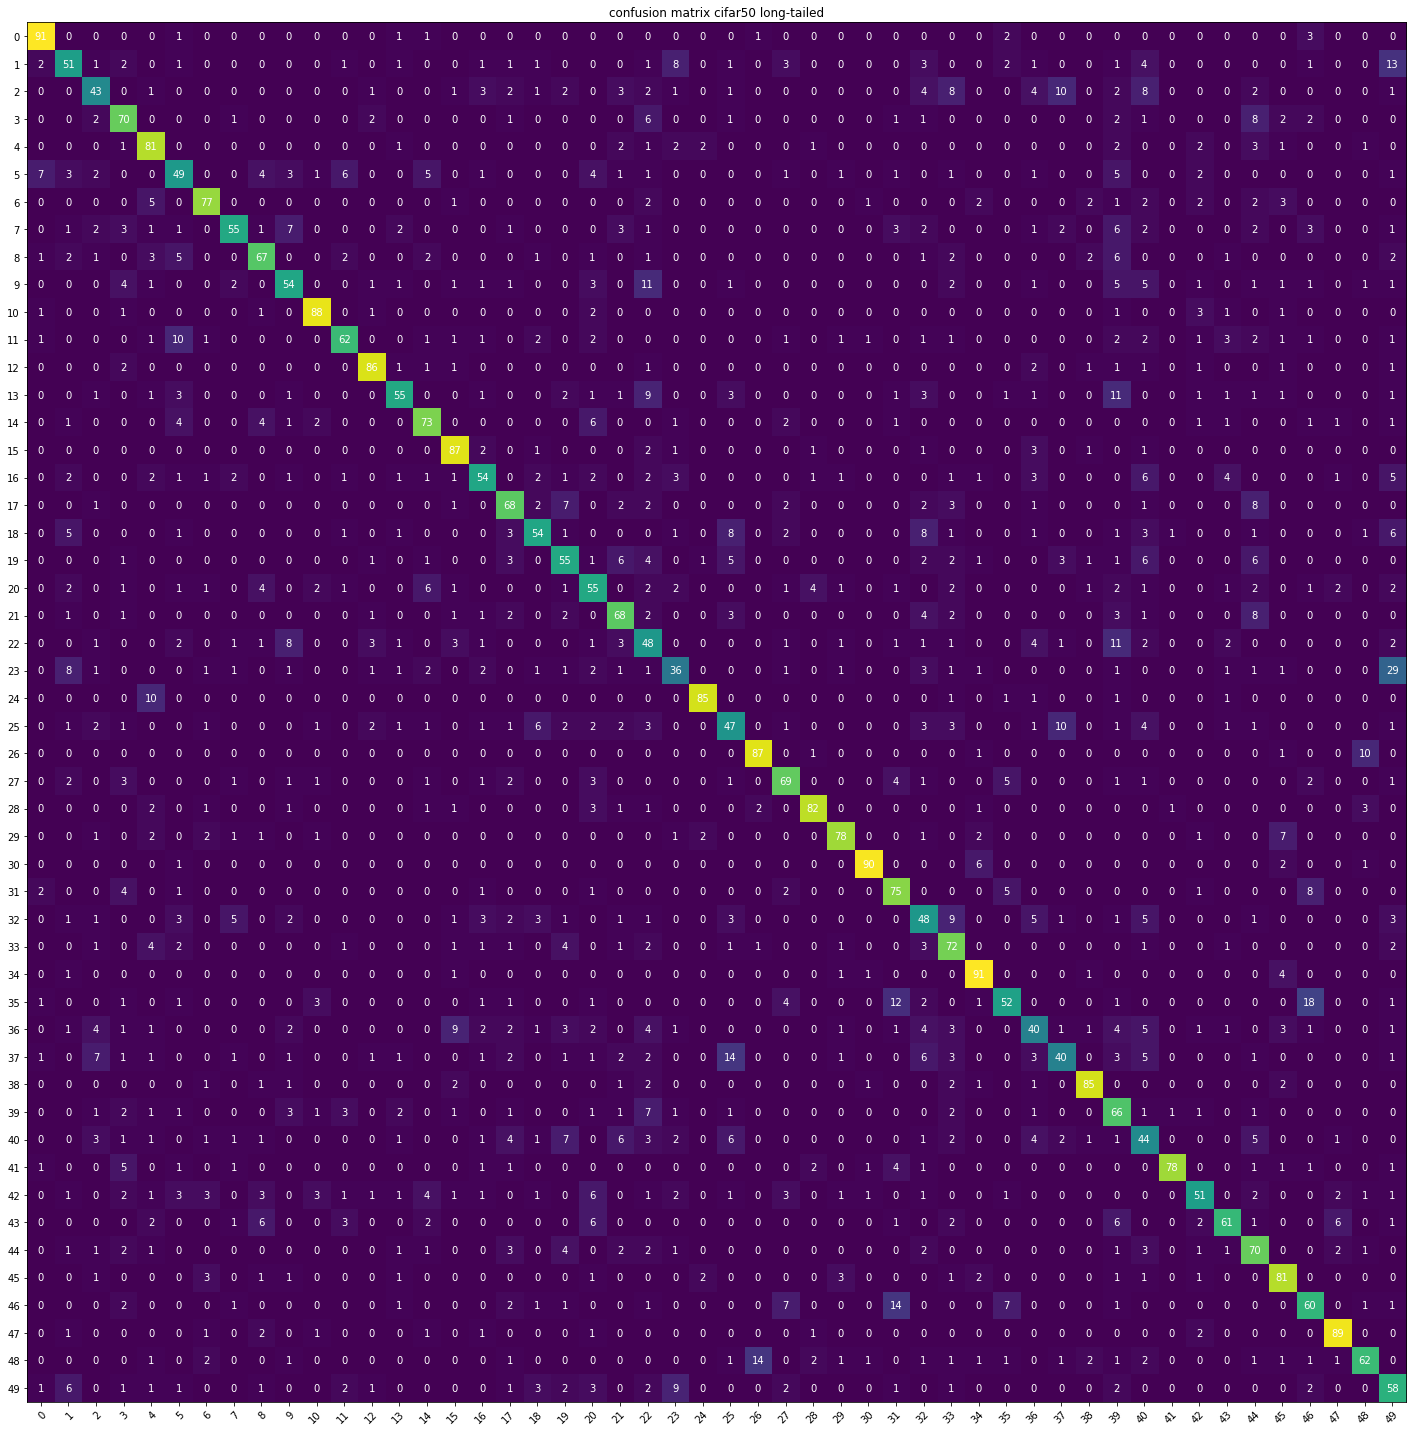

In [21]:
show_confusion_matrix(50, confusion_matrix)

# Long tailed classification with normal cnn model

LT p=0.1

In [16]:
# data preparation
test_transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     ])

my_transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     transforms.RandomApply(torch.nn.ModuleList([transforms.RandomAffine(degrees=0, translate=(0.1, 0.1))]), p=0.3),
     transforms.RandomHorizontalFlip(p=0.3),
     transforms.RandomApply(torch.nn.ModuleList([transforms.RandomRotation(degrees=45)]), p=0.3),
     transforms.RandomApply(torch.nn.ModuleList([transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2)]), p=0.3)
    ])

cifar50_train_01 = CustomImageDataset(annotations_file="D:\cifar-100-data\cifar50\cifar50_imbalance_0.1\cifar50_imbalance_0.1_train.json", transform=my_transform)
#cifar50_train_flip = CustomImageDataset(annotations_file="/content/gdrive/MyDrive/cifar50/cifar50/cifar50_train.json", transform=flip_transform)
#cifar50_train_rotate = CustomImageDataset(annotations_file="/content/gdrive/MyDrive/cifar50/cifar50/cifar50_train.json", transform=rotate_transform)
#cifar50_train_shift = CustomImageDataset(annotations_file="/content/gdrive/MyDrive/cifar50/cifar50/cifar50_train.json", transform=shift_transform)
#cifar50_train_noise = CustomImageDataset(annotations_file="/content/gdrive/MyDrive/cifar50/cifar50/cifar50_train.json", transform=noise_transform)

cifar50_test = CustomImageDataset(annotations_file="D:\cifar-100-data\cifar50\cifar50_imbalance_0.1\cifar50_imbalance_0.1_test.json", transform=test_transform)

#final_trainset = torch.utils.data.ConcatDataset([cifar50_train, cifar50_train_flip, cifar50_train_rotate,
                         #cifar50_train_shift, cifar50_train_noise])

print("Print the length of training dataset:\n ", len(cifar50_train_01))
print("Print the testing dataset:\n ", len(cifar50_test))
#print(len(cifar50_train))
#cifar50_train.show_idx("annotations", 0, "fpath")

train_loader_c50_LT01 = torch.utils.data.DataLoader(cifar50_train_01, batch_size=16, shuffle=True, drop_last=True)
test_loader_c50 = torch.utils.data.DataLoader(cifar50_test, batch_size=1, shuffle=False, drop_last=True)


Print the length of training dataset:
  9901
Print the testing dataset:
  5000


In [1]:
# long tailed function
u = 0.005
x = np.arange(start=50, stop=-0.5, step=-1)
n = 500 * (u**(x/50))
class_weights = n[1:].astype("int32")
print(class_weights)
plt.title("number of samples in each class")
plt.plot(x[1:], class_weights)
plt.show()

NameError: name 'np' is not defined

In [18]:
cnn = CNNCifar().to(device)
#cnn = CNN().to(device)
#cnn.load_state_dict(torch.load('/content/gdrive/MyDrive/cifar_LT01/525_cifarnet/cnn_cifar50_EPO_10.pth'))

# TODO: you can change loss function and optimizer
criterion = nn.CrossEntropyLoss() 
optimizer = optim.SGD(cnn.parameters(), lr=0.0001, momentum=0.9)



In [19]:
train_cnn("cifar50_LT01", train_loader_c50_LT01, cifar50_train_01)

D:\conda\lib\site-packages\torchvision\transforms\functional_tensor.py:876: UserWarning: Argument fill/fillcolor is not supported for Tensor input. Fill value is zero
  warnings.warn("Argument fill/fillcolor is not supported for Tensor input. Fill value is zero")


1 3.7198105459441537
2 3.561685342329245
3 3.4392880666208994
4 3.3460863365957008
5 3.2415035634242626
Accuracy of test datasets: 12 %
6 3.148090399150812
7 3.0637842133459134
8 2.9689280412953476
9 2.903943669325221
10 2.837317430615461
Accuracy of test datasets: 20 %
11 2.7801657931851134
12 2.7224296719699708
13 2.6694215725027135
14 2.613796488996251
15 2.5856889661737505
Accuracy of test datasets: 26 %
16 2.5091029507092135
17 2.48935973110879
18 2.4484099411335922
19 2.3913726531162536
20 2.353790912564602
Accuracy of test datasets: 30 %
21 2.31616912905754
22 2.264110307045241
23 2.261119014939182
24 2.223636122282533
25 2.180281926232051
Accuracy of test datasets: 35 %
26 2.15245882355436
27 2.1135994541610135
28 2.067995352475839
29 2.061969596705597
30 2.0243783744100776
Accuracy of test datasets: 39 %
31 2.001587185206142
32 1.9766277203041187
33 1.9482923935740997
34 1.9267173053736446
35 1.9147981528669473
Accuracy of test datasets: 41 %
36 1.8580006339455863
37 1.8549039

In [20]:
from sklearn.metrics import f1_score
# accuracy for each class
nb_classes = 50
cnn = CNNCifar().to(device)
cnn.load_state_dict(torch.load('D:\cnn_models\cifar50_LT01\cnn_cifar50_EPO_50.pth'))
confusion_matrix = torch.zeros(nb_classes, nb_classes)
y_preds = []
y_true = []
with torch.no_grad():
    cnn.eval()
    for data in test_loader_c50:
        inputs, classes = data[0].float().to(device), data[1].to(device).long()
        outputs = cnn(inputs)
        _, preds = torch.max(outputs, 1)
        y_preds.append(preds.item())
        y_true.append(classes.item())
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix.diag()/confusion_matrix.sum(1))

f1 = f1_score(y_true, y_preds, average='macro')
print("f1 score =", f1)

tensor([0.8900, 0.7300, 0.7200, 0.6500, 0.7800, 0.5900, 0.7600, 0.5100, 0.5900,
        0.5800, 0.8600, 0.5400, 0.7900, 0.5100, 0.6000, 0.8100, 0.4300, 0.5200,
        0.5100, 0.4800, 0.4400, 0.4600, 0.3100, 0.2000, 0.7500, 0.1600, 0.8900,
        0.5800, 0.5200, 0.6900, 0.8400, 0.5000, 0.1500, 0.2000, 0.5900, 0.5000,
        0.0800, 0.0200, 0.6500, 0.0300, 0.0000, 0.5800, 0.0700, 0.1800, 0.0200,
        0.0200, 0.0300, 0.4800, 0.2700, 0.0000])
f1 score = 0.4253207266454295


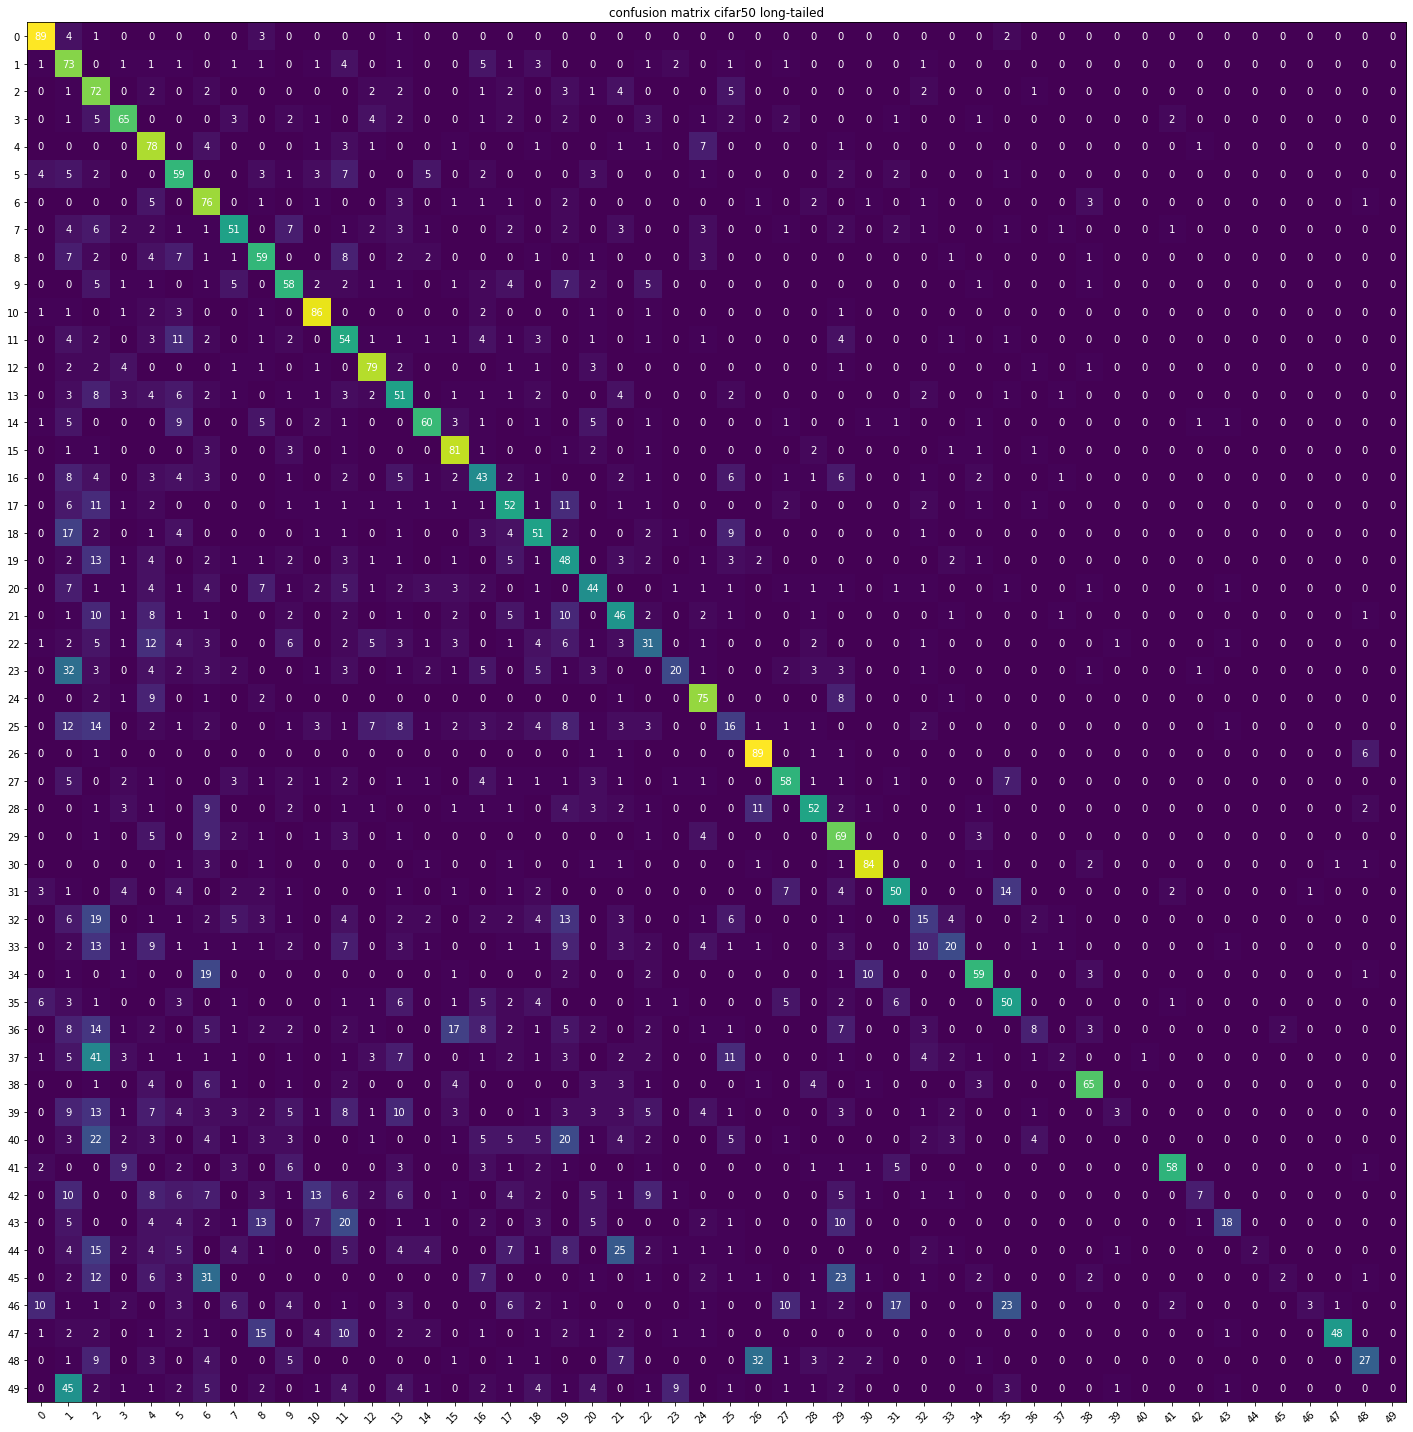

In [21]:
show_confusion_matrix(50, confusion_matrix)

# Long tailed cifar50 p=0.005

In [22]:
# data preparation
test_transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     ])

my_transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     transforms.RandomApply(torch.nn.ModuleList([transforms.RandomAffine(degrees=0, translate=(0.1, 0.1))]), p=0.3),
     transforms.RandomHorizontalFlip(p=0.3),
     transforms.RandomApply(torch.nn.ModuleList([transforms.RandomRotation(degrees=45)]), p=0.3),
     transforms.RandomApply(torch.nn.ModuleList([transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2)]), p=0.3)
    ])
cifar50_train_0005 = CustomImageDataset(annotations_file="D:\cifar-100-data\cifar50\cifar50_imbalance_0.005\cifar50_imbalance_0.005_train.json", transform=my_transform)
#cifar50_train_flip = CustomImageDataset(annotations_file="/content/gdrive/MyDrive/cifar50/cifar50/cifar50_train.json", transform=flip_transform)
#cifar50_train_rotate = CustomImageDataset(annotations_file="/content/gdrive/MyDrive/cifar50/cifar50/cifar50_train.json", transform=rotate_transform)
#cifar50_train_shift = CustomImageDataset(annotations_file="/content/gdrive/MyDrive/cifar50/cifar50/cifar50_train.json", transform=shift_transform)
#cifar50_train_noise = CustomImageDataset(annotations_file="/content/gdrive/MyDrive/cifar50/cifar50/cifar50_train.json", transform=noise_transform)

cifar50_test = CustomImageDataset(annotations_file="D:\cifar-100-data\cifar50\cifar50_imbalance_0.005\cifar50_imbalance_0.005_test.json", transform=test_transform)

#final_trainset = torch.utils.data.ConcatDataset([cifar50_train, cifar50_train_flip, cifar50_train_rotate,
                         #cifar50_train_shift, cifar50_train_noise])

print("Print the length of training dataset:\n ", len(cifar50_train_0005))
print("Print the testing dataset:\n ", len(cifar50_test))
#print(len(cifar50_train))
#cifar50_train.show_idx("annotations", 0, "fpath")

train_loader_c50_LT0005 = torch.utils.data.DataLoader(cifar50_train_0005, batch_size=16, shuffle=True, drop_last=True)
test_loader_c50 = torch.utils.data.DataLoader(cifar50_test, batch_size=1, shuffle=False, drop_last=True)


Print the length of training dataset:
  4878
Print the testing dataset:
  5000


In [24]:
cnn = CNNCifar().to(device)
#cnn = CNN().to(device)
#cnn.load_state_dict(torch.load('/content/gdrive/MyDrive/cifar_LT01/525_cifarnet/cnn_cifar50_EPO_10.pth'))

# TODO: you can change loss function and optimizer
criterion = nn.CrossEntropyLoss() 
optimizer = optim.SGD(cnn.parameters(), lr=0.0001, momentum=0.9)

In [25]:
train_cnn("cifar50_LT0005_new", train_loader_c50_LT0005, cifar50_train_0005, start=1)

D:\conda\lib\site-packages\torchvision\transforms\functional_tensor.py:876: UserWarning: Argument fill/fillcolor is not supported for Tensor input. Fill value is zero
  warnings.warn("Argument fill/fillcolor is not supported for Tensor input. Fill value is zero")


1 3.436317711298756
2 3.1160112336406263
3 2.995063496300704
4 2.896556720522497
5 2.820991507511053
Accuracy of test datasets: 8 %
6 2.745628367099864
7 2.690172137565034
8 2.62642339860479
9 2.5937847901485456
10 2.5402830568871178
Accuracy of test datasets: 11 %
11 2.4951691559075626
12 2.449889945123664
13 2.421407689418691
14 2.39585774802145
15 2.3515408411530405
Accuracy of test datasets: 14 %
16 2.3174008693593406
17 2.289056649702697
18 2.2530340317479407
19 2.234570353477888
20 2.176590311082478
Accuracy of test datasets: 16 %
21 2.1777639987283965
22 2.122626174028998
23 2.0915770313689923
24 2.0677490508082266
25 2.0500311708782677
Accuracy of test datasets: 17 %
26 2.0239740569555353
27 1.9848735792903736
28 1.9737470889981041
29 1.9408736195706988
30 1.9234024902600253
Accuracy of test datasets: 19 %
31 1.8801002232644244
32 1.875288338287779
33 1.854974251098445
34 1.8225007135392017
35 1.8153029268224887
Accuracy of test datasets: 20 %
36 1.7660130519952966
37 1.7613451

In [27]:
from sklearn.metrics import f1_score
# accuracy for each class
nb_classes = 50
cnn = CNNCifar().to(device)
cnn.load_state_dict(torch.load('D:\cnn_models\cifar50_LT0005_new\cnn_cifar50_EPO_50.pth'))
confusion_matrix = torch.zeros(nb_classes, nb_classes)
y_preds = []
y_true = []
with torch.no_grad():
    cnn.eval()
    for data in test_loader_c50:
        inputs, classes = data[0].float().to(device), data[1].to(device).long()
        outputs = cnn(inputs)
        _, preds = torch.max(outputs, 1)
        y_preds.append(preds.item())
        y_true.append(classes.item())
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix.diag()/confusion_matrix.sum(1))

f1 = f1_score(y_true, y_preds, average='macro')
print("f1 score =", f1)

tensor([0.9100, 0.6200, 0.8600, 0.8400, 0.6900, 0.4200, 0.8100, 0.5800, 0.5200,
        0.4100, 0.7300, 0.4100, 0.5800, 0.2100, 0.4800, 0.8200, 0.1900, 0.1100,
        0.2300, 0.0400, 0.0400, 0.1700, 0.0000, 0.0000, 0.1900, 0.0000, 0.9100,
        0.1300, 0.0000, 0.0000, 0.2300, 0.0400, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
f1 score = 0.17173339501198384


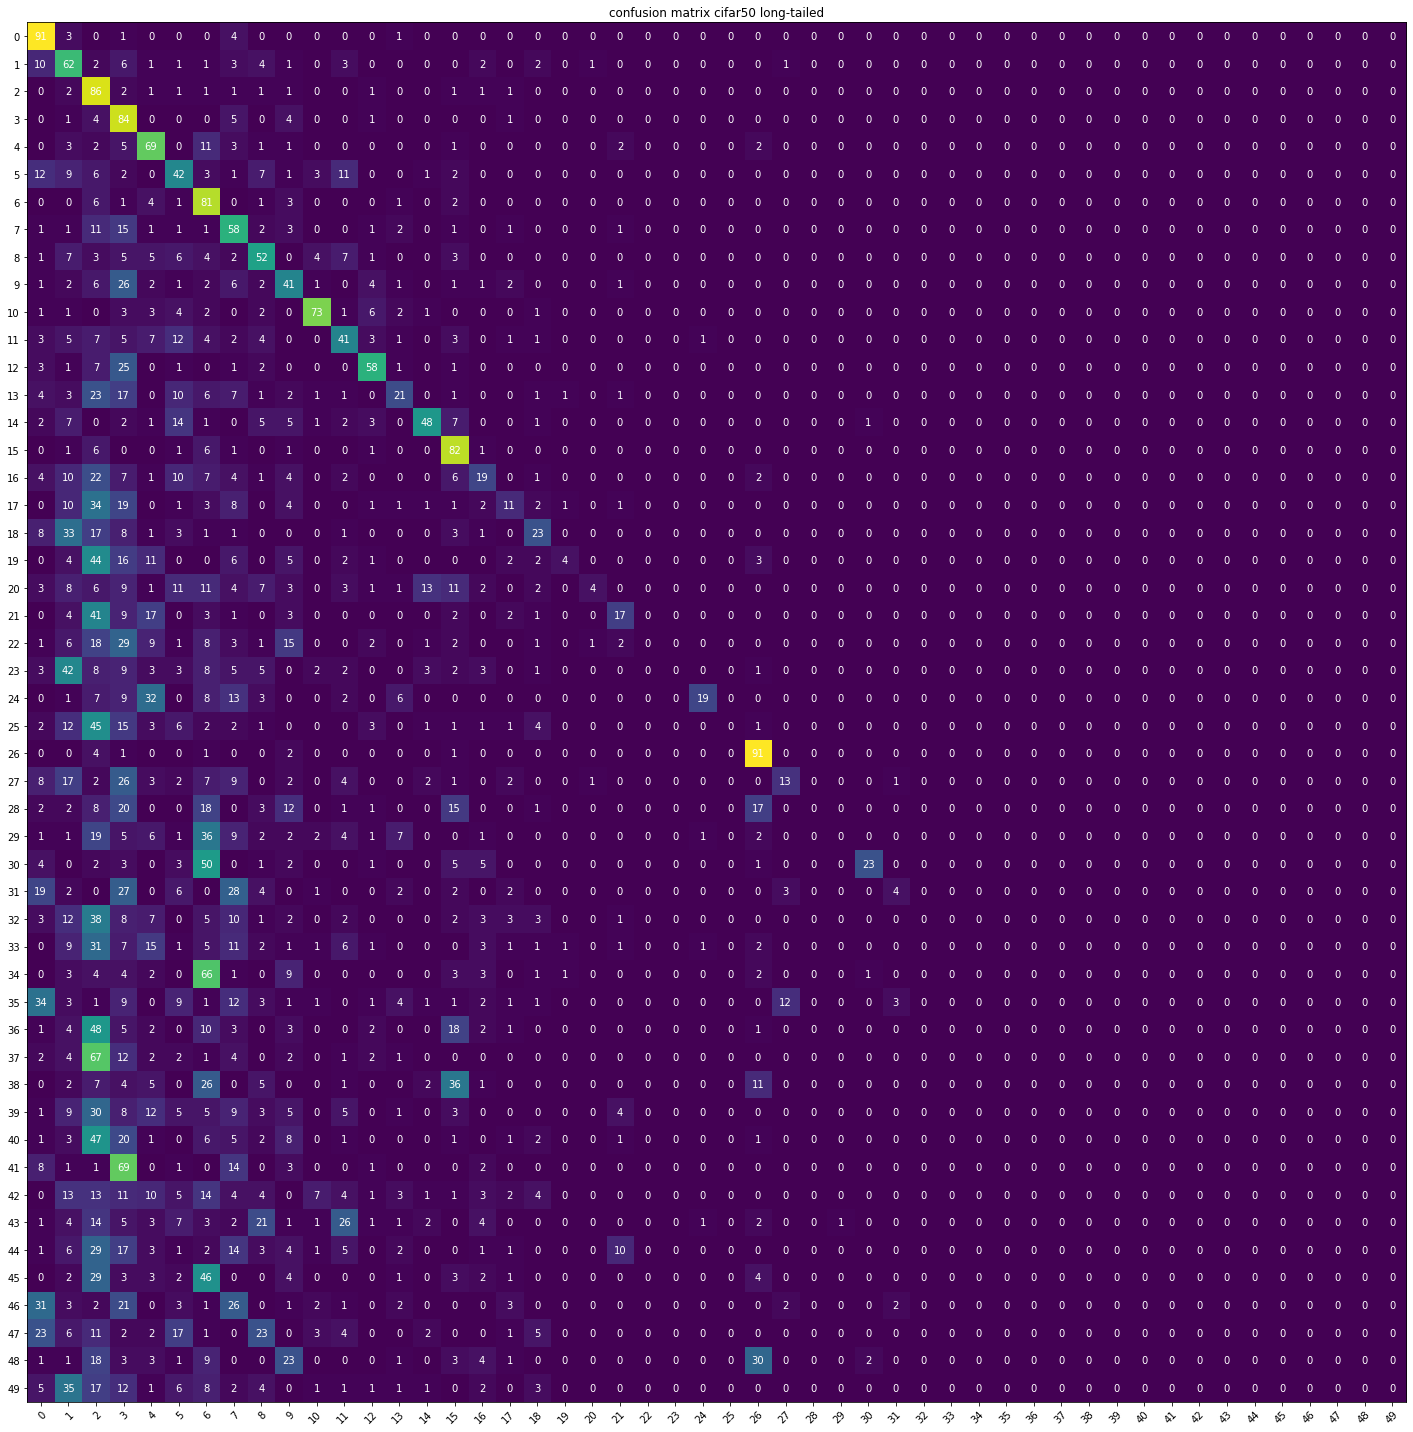

In [28]:
show_confusion_matrix(50, confusion_matrix)

# run cifar50 with p=0.02

In [32]:
# data preparation
test_transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     ])

my_transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     transforms.RandomApply(torch.nn.ModuleList([transforms.RandomAffine(degrees=0, translate=(0.1, 0.1))]), p=0.3),
     transforms.RandomHorizontalFlip(p=0.3),
     transforms.RandomApply(torch.nn.ModuleList([transforms.RandomRotation(degrees=45)]), p=0.3),
     transforms.RandomApply(torch.nn.ModuleList([transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2)]), p=0.3)
    ])

cifar50_train_002 = CustomImageDataset(annotations_file="D:\cifar-100-data\cifar50\cifar50_imbalance_0.02\cifar50_imbalance_0.02_train.json", transform=my_transform)
#cifar50_train_flip = CustomImageDataset(annotations_file="/content/gdrive/MyDrive/cifar50/cifar50/cifar50_train.json", transform=flip_transform)
#cifar50_train_rotate = CustomImageDataset(annotations_file="/content/gdrive/MyDrive/cifar50/cifar50/cifar50_train.json", transform=rotate_transform)
#cifar50_train_shift = CustomImageDataset(annotations_file="/content/gdrive/MyDrive/cifar50/cifar50/cifar50_train.json", transform=shift_transform)
#cifar50_train_noise = CustomImageDataset(annotations_file="/content/gdrive/MyDrive/cifar50/cifar50/cifar50_train.json", transform=noise_transform)

cifar50_test = CustomImageDataset(annotations_file="D:\cifar-100-data\cifar50\cifar50_imbalance_0.02\cifar50_imbalance_0.02_test.json", transform=test_transform)

#final_trainset = torch.utils.data.ConcatDataset([cifar50_train, cifar50_train_flip, cifar50_train_rotate,
                         #cifar50_train_shift, cifar50_train_noise])

print("Print the length of training dataset:\n ", len(cifar50_train_002))
print("Print the testing dataset:\n ", len(cifar50_test))
#print(len(cifar50_train))
#cifar50_train.show_idx("annotations", 0, "fpath")

train_loader_c50_LT002 = torch.utils.data.DataLoader(cifar50_train_002, batch_size=16, shuffle=True, drop_last=True)
test_loader_c50 = torch.utils.data.DataLoader(cifar50_test, batch_size=1, shuffle=False, drop_last=True)


Print the length of training dataset:
  6430
Print the testing dataset:
  5000


In [33]:
from torchvision import models
cnn = CNNCifar().to(device)
#cnn.load_state_dict(torch.load('/content/gdrive/MyDrive/cifar_LT01/525_cifarnet/cnn_cifar50_EPO_10.pth'))

# TODO: you can change loss function and optimizer
criterion = nn.CrossEntropyLoss() 
optimizer = optim.SGD(cnn.parameters(), lr=0.0001, momentum=0.9)

In [34]:
train_cnn("cifar50_LT002", train_loader_c50_LT002, cifar50_train_002)

D:\conda\lib\site-packages\torchvision\transforms\functional_tensor.py:876: UserWarning: Argument fill/fillcolor is not supported for Tensor input. Fill value is zero
  warnings.warn("Argument fill/fillcolor is not supported for Tensor input. Fill value is zero")


1 3.5434725813324306
2 3.317825518499822
3 3.2142209422347334
4 3.1225957606480246
5 3.0389328981817787
Accuracy of test datasets: 9 %
6 2.9723906687592643
7 2.887877102402469
8 2.8358870875594406
9 2.7641773366260676
10 2.7134164317770284
Accuracy of test datasets: 13 %
11 2.6616498778062883
12 2.6006355967899872
13 2.558949267919846
14 2.519479702345876
15 2.474574985474487
Accuracy of test datasets: 17 %
16 2.434608118048352
17 2.402367369086709
18 2.3544404443648888
19 2.3109956818457524
20 2.2725534050498
Accuracy of test datasets: 22 %
21 2.2444325920211767
22 2.215343296472244
23 2.186011997240698
24 2.1597281940988213
25 2.1219611946568704
Accuracy of test datasets: 23 %
26 2.0974042133076196
27 2.0783247689622373
28 2.0476345968468936
29 2.029333469100169
30 1.987299176953258
Accuracy of test datasets: 27 %
31 1.9740724581396598
32 1.9572741566327274
33 1.9203989637027818
34 1.8970102063975476
35 1.8779570511303274
Accuracy of test datasets: 27 %
36 1.8460511938780315
37 1.838

In [22]:
from sklearn.metrics import f1_score
# accuracy for each class
def show_f1(nb_classes, path):
    cnn = CNNCifar().to(device)
    cnn.load_state_dict(torch.load(path))
    confusion_matrix = torch.zeros(nb_classes, nb_classes)
    y_preds = []
    y_true = []
    with torch.no_grad():
        cnn.eval()
        for data in test_loader_c50:
            inputs, classes = data[0].float().to(device), data[1].to(device).long()
            outputs = cnn(inputs)
            _, preds = torch.max(outputs, 1)
            y_preds.append(preds.item())
            y_true.append(classes.item())
            for t, p in zip(classes.view(-1), preds.view(-1)):
                    confusion_matrix[t.long(), p.long()] += 1

    print(confusion_matrix.diag()/confusion_matrix.sum(1))

    f1 = f1_score(y_true, y_preds, average='macro')
    print("f1 score =", f1)
    return confusion_matrix

In [39]:
confusion_matrix = show_f1(50, 'D:\cnn_models\cifar50_LT002\cnn_cifar50_EPO_50.pth')

tensor([0.8700, 0.8200, 0.7200, 0.5900, 0.8300, 0.5400, 0.7900, 0.4700, 0.5100,
        0.7000, 0.8300, 0.4700, 0.7200, 0.3500, 0.7100, 0.7900, 0.2300, 0.2400,
        0.4000, 0.3000, 0.2400, 0.1900, 0.0600, 0.1300, 0.3800, 0.0000, 0.9100,
        0.3900, 0.3100, 0.1600, 0.7600, 0.4500, 0.0000, 0.0000, 0.2900, 0.2500,
        0.0000, 0.0000, 0.0900, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
f1 score = 0.2677254437944484


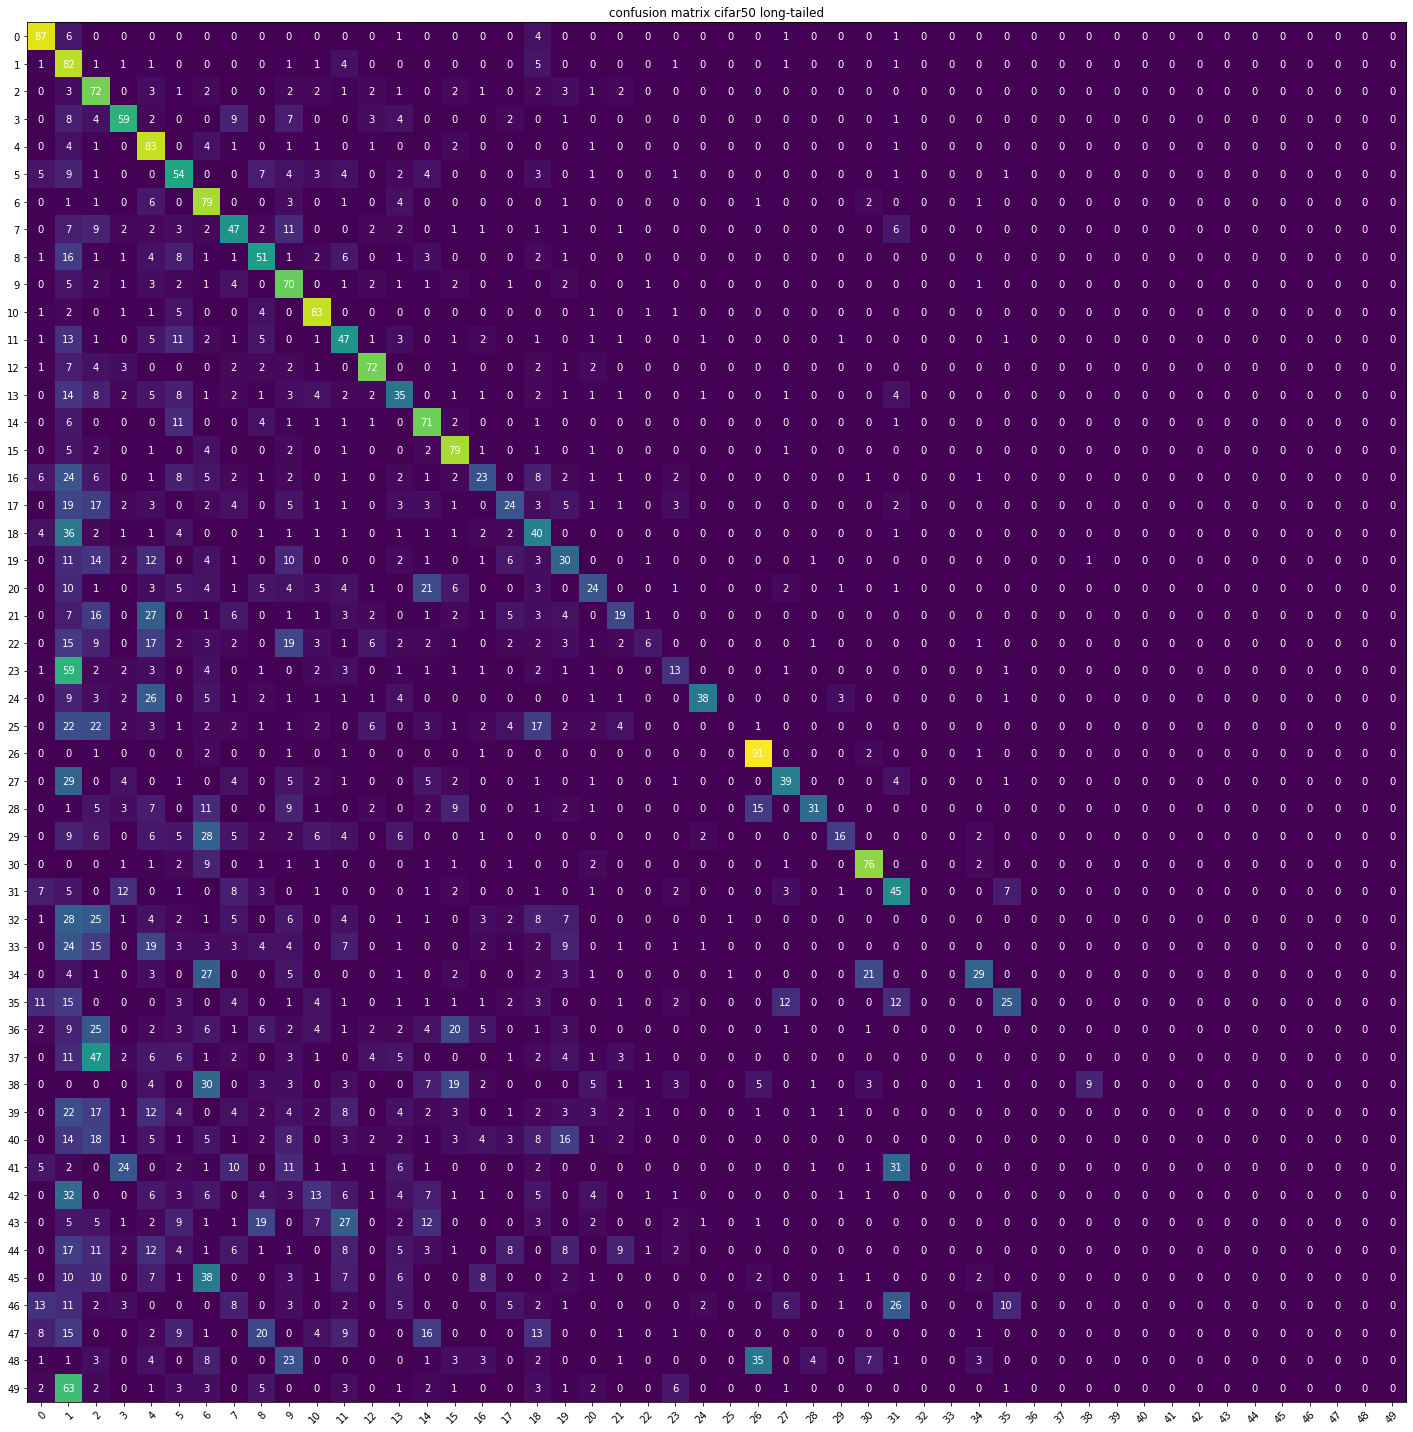

In [40]:
show_confusion_matrix(50, confusion_matrix)

# improve cnn performance on long-tailed dataset

Use WeightedRandomSampler to reweight each class, p=0.005

In [41]:
# long tailed function
u = 0.005
x = np.arange(start=1, stop=-0.01, step=-0.02)
n = 500 * (u**x)
class_weights = n[1:]
print(class_weights)
# samp_weights = [0] * len(cifar50_train_0005)
# for idx in range(len(cifar50_train_0005)):
#     img, label = cifar50_train_0005[idx]
#     weight = class_weights[int(label)]
#     samp_weights[idx] = weight


[  2.77946115   3.09016172   3.43559378   3.81963979   4.24661616
   4.72132186   5.24909228   5.83585924   6.48821762   7.21349953
   8.01985669   8.91635205   9.91306166  11.02118792  12.25318547
  13.62290121  15.14572989  16.83878714  18.72110189  20.81383019
  23.14049298  25.72724052  28.60314625  31.80053355  35.35533906
  39.30751659  43.70148616  48.58663325  54.01786388  60.0562217
  66.76957409  74.23337497  82.5315128   91.75725351 102.01428867
 113.41790098 126.09625995 140.19186245 155.86313428 173.28621079
 192.65691652 214.19296616 238.13641152 264.75636201 294.35200933
 327.25599014 363.83812473 404.50957352 449.72745831 500.        ]


In [42]:
# data preparation
my_transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     ])

cifar50_train_0005 = CustomImageDataset(annotations_file="D:\cifar-100-data\cifar50\cifar50_imbalance_0.005\cifar50_imbalance_0.005_train.json", transform=my_transform)
cifar50_test = CustomImageDataset(annotations_file="D:\cifar-100-data\cifar50\cifar50_imbalance_0.005\cifar50_imbalance_0.005_test.json", transform=my_transform)



# long tailed function
u = 0.005
x = np.arange(start=1, stop=-0.01, step=-0.02)
n = 500 * (u**x)
class_weights = n[1:]
#print(class_weights)
samp_weights = [0] * len(cifar50_train_0005)
for idx in range(len(cifar50_train_0005)):
    img, label = cifar50_train_0005[idx]
    weight = class_weights[int(label)]
    samp_weights[idx] = weight
    
my_sampler = WeightedRandomSampler(samp_weights, num_samples=len(samp_weights), replacement=True)


train_loader_c50_LT0005 = torch.utils.data.DataLoader(cifar50_train_0005, batch_size=16, shuffle=False, drop_last=True, sampler=my_sampler)
test_loader_c50 = torch.utils.data.DataLoader(cifar50_test, batch_size=1, shuffle=False, drop_last=True)
print(len(train_loader_c50_LT0005.dataset))

D:\conda\lib\site-packages\torchvision\transforms\functional_tensor.py:876: UserWarning: Argument fill/fillcolor is not supported for Tensor input. Fill value is zero
  warnings.warn("Argument fill/fillcolor is not supported for Tensor input. Fill value is zero")


4878


In [43]:
cnn = CNNCifar().to(device)
#cnn = CNN().to(device)
#cnn.load_state_dict(torch.load('/content/gdrive/MyDrive/cifar_LT01/525_cifarnet/cnn_cifar50_EPO_10.pth'))

# TODO: you can change loss function and optimizer
criterion = nn.CrossEntropyLoss() 
optimizer = optim.SGD(cnn.parameters(), lr=0.0001, momentum=0.9)


In [65]:
train_cnn("cifar50_LT0005_weighted_sampler", train_loader_c50_LT0005, cifar50_train_0005)

1 61.95991665438602
2 60.07829966043171
3 58.15212698986656
4 55.38181145567643
5 53.05562124754253
Accuracy of test datasets: 14 %
6 50.45918809740167
7 47.7964806933152
8 44.85545149602388
9 42.65166199834723
10 40.432029849604554
Accuracy of test datasets: 20 %
11 38.09435691958979
12 35.36741826408788
13 33.52438693297537
14 31.71792935697656
15 29.711415676694166
Accuracy of test datasets: 24 %
16 28.212607838605578
17 26.4931730063338
18 25.23501865173641
19 23.3574809839851
20 22.372734254912327
Accuracy of test datasets: 26 %
21 21.314949606594286
22 20.411853467163287
23 18.933937220196974
24 17.88773866233073
25 17.18870422244072
Accuracy of test datasets: 28 %
26 16.17005233388198
27 15.872874416803059
28 14.80477183272964
29 14.154235882194419
30 13.528670568215219
Accuracy of test datasets: 28 %
31 12.396844688999025
32 12.201428562402725
33 10.850458542767324
34 11.335578114578599
35 10.367195258407216
Accuracy of test datasets: 28 %
36 9.913422662960855
37 9.324420789746

In [66]:
from sklearn.metrics import f1_score
# accuracy for each class
nb_classes = 50
cnn = CNNCifar().to(device)
cnn.load_state_dict(torch.load('D:\cnn_models\cifar50_LT0005_weighted_sampler\cnn_cifar50_EPO_50.pth'))
confusion_matrix = torch.zeros(nb_classes, nb_classes)
y_preds = []
y_true = []
with torch.no_grad():
    cnn.eval()
    for data in test_loader_c50:
        inputs, classes = data[0].float().to(device), data[1].to(device).long()
        outputs = cnn(inputs)
        _, preds = torch.max(outputs, 1)
        y_preds.append(preds.item())
        y_true.append(classes.item())
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix.diag()/confusion_matrix.sum(1))

f1 = f1_score(y_true, y_preds, average='macro')
print("f1 score =", f1)

tensor([0.8600, 0.5700, 0.6600, 0.6200, 0.6200, 0.4400, 0.6600, 0.3800, 0.5200,
        0.6100, 0.7400, 0.4800, 0.8200, 0.2400, 0.6500, 0.7500, 0.4400, 0.2900,
        0.3100, 0.3300, 0.2200, 0.1900, 0.1900, 0.0600, 0.2200, 0.0500, 0.8400,
        0.3000, 0.2100, 0.0800, 0.8000, 0.3200, 0.0200, 0.0000, 0.2600, 0.0100,
        0.0100, 0.0000, 0.2400, 0.0100, 0.0100, 0.1400, 0.0000, 0.0100, 0.0000,
        0.0100, 0.0000, 0.0000, 0.0100, 0.0000])
f1 score = 0.24666683613774978


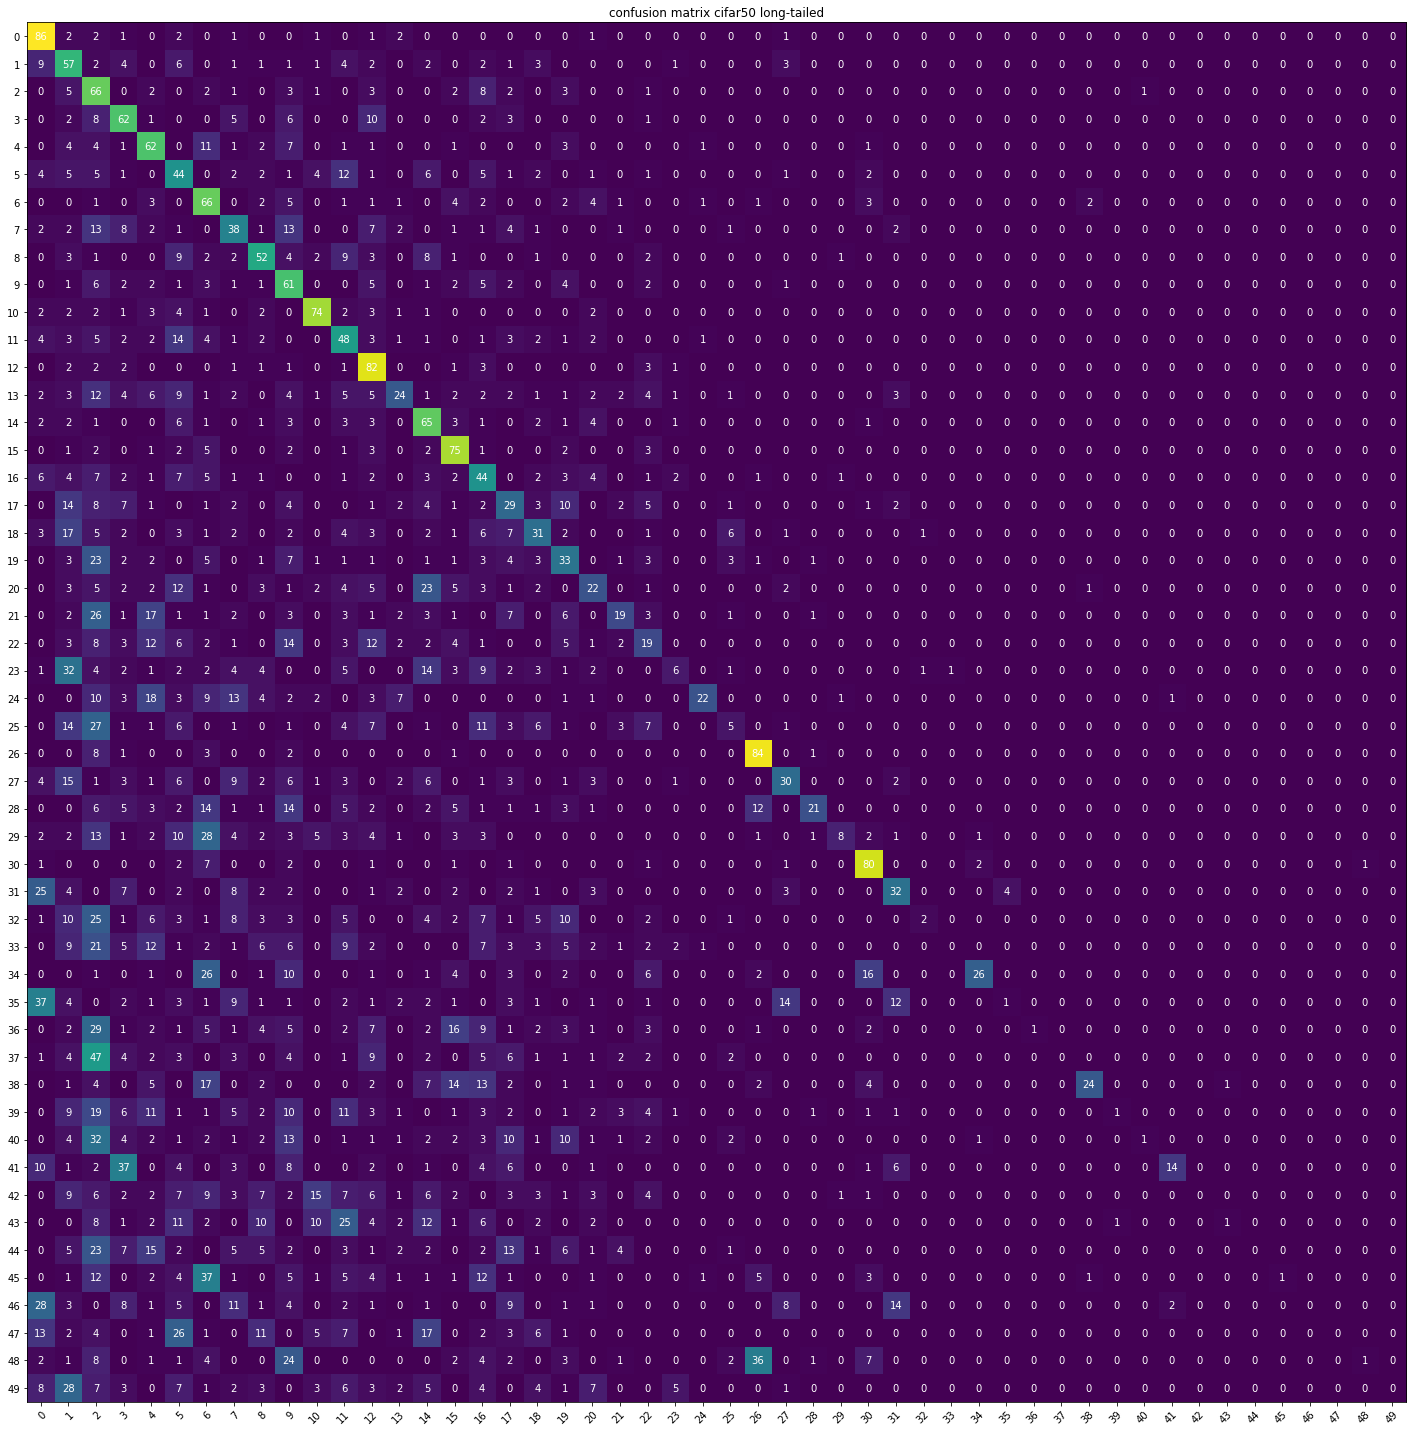

In [67]:
fig, ax = plt.subplots()
im = ax.imshow(confusion_matrix)

# We want to show all ticks...
ax.set_xticks(np.arange(50))
ax.set_yticks(np.arange(50))
# ... and label them with the respective list entries
#ax.set_xticklabels()
#ax.set_yticklabels()

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.

for i in range(50):
    for j in range(50):
        text = ax.text(j, i, int(confusion_matrix[i][j].item()),
                       ha="center", va="center", color="w")



ax.set_title("confusion matrix cifar50 long-tailed")
fig.set_size_inches(20,20)
fig.tight_layout()
plt.show()

[ 10  11  12  13  14  15  17  18  20  21  23  25  27  29  32  34  37  40
  44  47  51  55  60  65  70  76  82  89  96 104 113 122 132 142 154 167
 180 195 211 228 247 267 289 312 338 365 395 427 462 500]


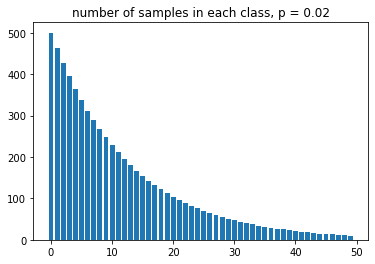

In [12]:
# long tailed function
u = 0.02
x = np.arange(start=50, stop=-0.5, step=-1)
n = 500 * (u**(x/50))
class_weights = n[1:].astype("int32")
print(class_weights)
plt.title("number of samples in each class, p = " + str(u))
plt.bar(x[1:], class_weights)
plt.show()

Weighted sampler combined with data augmentation

In [8]:
# data preparation

my_transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     transforms.RandomApply(torch.nn.ModuleList([transforms.RandomAffine(degrees=0, translate=(0.1, 0.1))]), p=0.3),
     transforms.RandomHorizontalFlip(p=0.3),
     transforms.RandomApply(torch.nn.ModuleList([transforms.RandomRotation(degrees=45)]), p=0.3),
     transforms.RandomApply(torch.nn.ModuleList([transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2)]), p=0.3)
    ])



cifar50_train_0005 = CustomImageDataset(annotations_file="D:\cifar-100-data\cifar50\cifar50_imbalance_0.005\cifar50_imbalance_0.005_train.json", transform=my_transform)
#cifar50_train_flip = CustomImageDataset(annotations_file="/content/gdrive/MyDrive/cifar50/cifar50/cifar50_train.json", transform=flip_transform)
#cifar50_train_rotate = CustomImageDataset(annotations_file="/content/gdrive/MyDrive/cifar50/cifar50/cifar50_train.json", transform=rotate_transform)
#cifar50_train_shift = CustomImageDataset(annotations_file="/content/gdrive/MyDrive/cifar50/cifar50/cifar50_train.json", transform=shift_transform)
#cifar50_train_noise = CustomImageDataset(annotations_file="/content/gdrive/MyDrive/cifar50/cifar50/cifar50_train.json", transform=noise_transform)

cifar50_test = CustomImageDataset(annotations_file="D:\cifar-100-data\cifar50\cifar50_imbalance_0.005\cifar50_imbalance_0.005_test.json", transform=transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
     ]))



# long tailed function
u = 0.005
x = np.arange(start=1, stop=-0.01, step=-0.02)
n = 500 * (u**x)
class_weights = n[1:]
print(class_weights)
samp_weights = [0] * len(cifar50_train_0005)
for idx in range(len(cifar50_train_0005)):
    img, label = cifar50_train_0005[idx]
    weight = class_weights[int(label)]
    samp_weights[idx] = weight
    
my_sampler = WeightedRandomSampler(samp_weights, num_samples=len(samp_weights), replacement=True)


train_loader_c50_LT0005 = torch.utils.data.DataLoader(cifar50_train_0005, batch_size=16, shuffle=False, drop_last=True, sampler=my_sampler)
test_loader_c50 = torch.utils.data.DataLoader(cifar50_test, batch_size=1, shuffle=False, drop_last=True)
print(len(train_loader_c50_LT0005.dataset))

[  2.77946115   3.09016172   3.43559378   3.81963979   4.24661616
   4.72132186   5.24909228   5.83585924   6.48821762   7.21349953
   8.01985669   8.91635205   9.91306166  11.02118792  12.25318547
  13.62290121  15.14572989  16.83878714  18.72110189  20.81383019
  23.14049298  25.72724052  28.60314625  31.80053355  35.35533906
  39.30751659  43.70148616  48.58663325  54.01786388  60.0562217
  66.76957409  74.23337497  82.5315128   91.75725351 102.01428867
 113.41790098 126.09625995 140.19186245 155.86313428 173.28621079
 192.65691652 214.19296616 238.13641152 264.75636201 294.35200933
 327.25599014 363.83812473 404.50957352 449.72745831 500.        ]


D:\conda\lib\site-packages\torchvision\transforms\functional_tensor.py:876: UserWarning: Argument fill/fillcolor is not supported for Tensor input. Fill value is zero
  warnings.warn("Argument fill/fillcolor is not supported for Tensor input. Fill value is zero")


4878


In [9]:
# cnn = CNNCifar().to(device)
cnn = CNNCifar().to(device)
cnn.load_state_dict(torch.load("D:\cnn_models\cifar50_LT0005_weighted_sampler_data_aug\cnn_cifar50_EPO_100.pth"))

# TODO: you can change loss function and optimizer
criterion = nn.CrossEntropyLoss() 
optimizer = optim.SGD(cnn.parameters(), lr=0.0001, momentum=0.9)


In [10]:
train_cnn("cifar50_LT0005_weighted_sampler_data_aug", train_loader_c50_LT0005, cifar50_train_0005, start=101)

101 0.6747296609170811
102 0.688817526825924
103 0.6611747811347942
104 0.6589125205914277
105 0.6819030222417684
Accuracy of test datasets: 35 %
106 0.6752787702588968
107 0.6427916797666874
108 0.667840731148839
109 0.6330468594514722
110 0.6371200671446231
Accuracy of test datasets: 34 %
111 0.6151287072552379
112 0.6094807730487449
113 0.6370717788778792
114 0.6025431893946158
115 0.610260341489056
Accuracy of test datasets: 34 %
116 0.6156181730956218
117 0.6023726015488795
118 0.6035818513811196
119 0.6151714000168175
120 0.5968274863321501
Accuracy of test datasets: 35 %
121 0.571761852554143
122 0.5752029326935683
123 0.6115492190149975
124 0.5714270380639112
125 0.5470897524070427
Accuracy of test datasets: 35 %
126 0.5658253283469391
127 0.5542892211770952
128 0.536370352796474
129 0.5300495688203614
130 0.5328733904799656
Accuracy of test datasets: 35 %
131 0.5719563957607712
132 0.5277645959503194
133 0.5429667539408872
134 0.5358851506188054
135 0.5208037368412534
Accuracy

In [ ]:
1 3.8743696756272983
2 3.8180295436682394
3 3.7484449462452694
4 3.6622348572690746
5 3.576810756243854
Accuracy of test datasets: 10 %
6 3.489500045776367
7 3.3884079296992615
8 3.307471848941817
9 3.1993696768785314
10 3.136657668704525
Accuracy of test datasets: 16 %
11 3.0437947265825196
12 2.9783447526819935
13 2.870563078532702
14 2.789301939507203
15 2.711597081333362
Accuracy of test datasets: 19 %
16 2.6623361320855334
17 2.5535637690132393
18 2.457890453080556
19 2.4281458754967646
20 2.3287063948978113
Accuracy of test datasets: 23 %
21 2.2952685252522387
22 2.2178777618064114
23 2.1889517363000475
24 2.106663457972928
25 2.030979791103987
Accuracy of test datasets: 26 %
26 2.0162212849640855
27 1.9593784626315196
28 1.920738509562525
29 1.9006880587757293
30 1.8423440220806626
Accuracy of test datasets: 28 %
31 1.7959700571117267
32 1.7602636349792606
33 1.7468306874583714
34 1.6878753128771218
35 1.7058816597372746
Accuracy of test datasets: 29 %
36 1.6733497372901356
37 1.6101273851054474
38 1.5742384489074306
39 1.5563784460886525
40 1.5366854912045063
Accuracy of test datasets: 30 %
41 1.5294802752905763
42 1.4579435689080782
43 1.4458700463927248
44 1.4129167205244364
45 1.4154894686273103
Accuracy of test datasets: 31 %
46 1.3489992122955135
47 1.3642283228881635
48 1.3213996133534525
49 1.2975870778004426
50 1.2985867120634096
Accuracy of test datasets: 32 %
Finished Training
[57.39369364788658, 50.33097403927853, 43.51042948271099, 37.366545376024746, 32.58920862172779, 29.56234914378116, 27.372666895389557, 24.657736270051252, 22.71301851303954, 20.83719072843853]
[10.22, 16.02, 19.92, 23.66, 26.1, 28.28, 29.26, 30.44, 31.12, 32.0]

51 1.2487125527716993
52 1.22654324449834
53 1.2310540918543378
54 1.2144969034605506
55 1.1848075211952338
Accuracy of test datasets: 32 %
56 1.145526896152598
57 1.1829683823681307
58 1.1378159283516396
59 1.105718432219608
60 1.061726630638251
Accuracy of test datasets: 33 %
61 1.0903356521038698
62 1.048754354146916
63 1.060245993881257
64 1.0294267285696157
65 1.023263485815839
Accuracy of test datasets: 33 %
66 0.9962814932428652
67 0.9983561888440997
68 1.0048763746118488
69 0.9871462486278039
70 0.9311913702516293
Accuracy of test datasets: 34 %
71 0.9513967782564464
72 0.9028761307202973
73 0.9302394190690908
74 0.902329449332997
75 0.9276934637794635
Accuracy of test datasets: 34 %
76 0.8840107965684416
77 0.8733767805748565
78 0.8713903097209016
79 0.8592955478638497
80 0.8605764552480425
Accuracy of test datasets: 34 %
81 0.8268508426279941
82 0.8074166445567892
83 0.8153540453689907
84 0.8159815557866177
85 0.8189515128102445
Accuracy of test datasets: 34 %
86 0.8083534111689231
87 0.7777997540762894
88 0.7795210728492831
89 0.7783733257361737
90 0.7571016380463335
Accuracy of test datasets: 34 %
91 0.750806231658055
92 0.7670593353117426
93 0.7498817021556446
94 0.7011867604230261
95 0.7433669233283042
Accuracy of test datasets: 34 %
96 0.7184753178474892
97 0.7281977228084124
98 0.6926914230141791
99 0.6945587021251739
100 0.7039084241447903
Accuracy of test datasets: 35 %
Finished Training
[19.01148384338931, 17.036521395570354, 16.419339749373886, 14.941945737129764, 14.88581814577705, 13.808855094407734, 13.140939077264385, 12.148492731546101, 11.928104776300883, 11.2949516216391]
[32.86, 33.52, 33.38, 34.0, 34.96, 34.5, 34.42, 34.78, 34.98, 35.86]

In [57]:
from sklearn.metrics import f1_score
confusion_matrix = show_f1(50, "D:\cnn_models\cifar50_LT0005_weighted_sampler_data_aug\cnn_cifar50_EPO_100.pth")

tensor([0.8700, 0.5400, 0.4100, 0.6000, 0.6500, 0.5000, 0.7400, 0.5700, 0.5900,
        0.5500, 0.8000, 0.4300, 0.8300, 0.3600, 0.6200, 0.7900, 0.3000, 0.4400,
        0.4100, 0.3600, 0.2900, 0.2900, 0.1800, 0.1800, 0.5300, 0.0700, 0.8300,
        0.3800, 0.4000, 0.5200, 0.8700, 0.3100, 0.0200, 0.0800, 0.4700, 0.1800,
        0.0400, 0.0400, 0.4300, 0.0200, 0.0200, 0.1200, 0.0200, 0.1300, 0.0100,
        0.0200, 0.0100, 0.0600, 0.0500, 0.0000])
f1 score = 0.31073795947924554


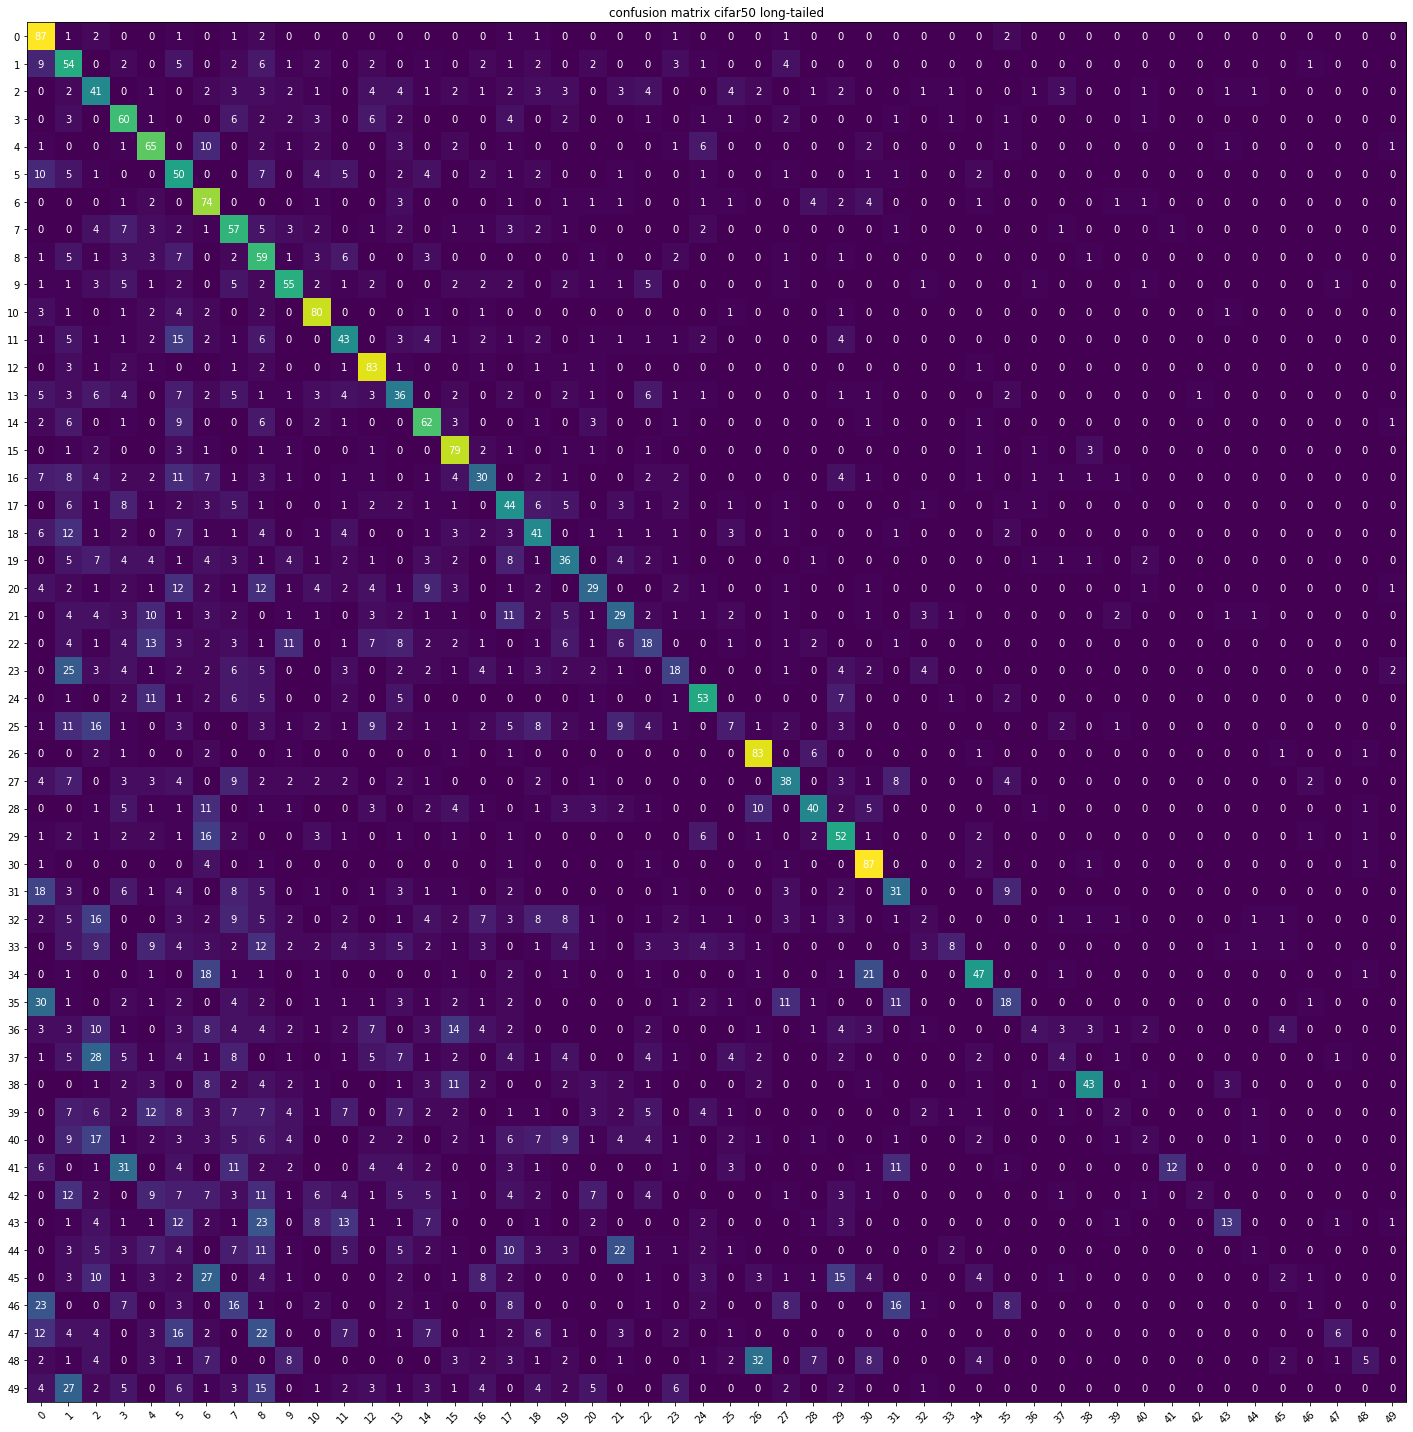

In [58]:
show_confusion_matrix(50, confusion_matrix)

Improved weight assign

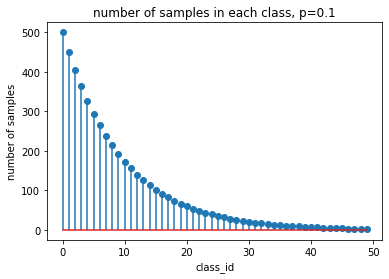

In [99]:
u = 0.005
x = np.arange(start=0, stop=50, step=1)
n = 500 * (u**(x/50))
n_samples_class = n[:50]
plt.title("number of samples in each class, p=0.1")
plt.xlabel("class_id")
plt.ylabel("number of samples")
plt.stem(n_samples_class)
plt.show()

[ 0.2572      0.27813162  0.30076671  0.3252439   0.35171312  0.38033646
  0.41128926  0.44476107  0.48095691  0.52009846  0.56242545  0.60819713
  0.65769383  0.7112187   0.76909956  0.83169093  0.89937615  0.97256977
  1.05172008  1.13731185  1.22986931  1.32995935  1.43819497  1.5552391
  1.68180859  1.81867864  1.96668754  2.1267418   2.2998217   2.4869873
  2.68938493  2.90825422  3.14493568  3.4008789   3.67765146  3.9769485
  4.30060314  4.65059765  5.02907564  5.43835518  5.88094297  6.35954973
  6.87710678  7.43678401  8.04200925  8.69648932  9.40423273 10.16957417
 10.99720114 11.89218259]


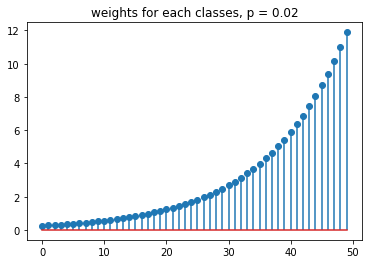

In [25]:
# w = (n)/(n_j * n_classes)
# long tailed function

u = 0.02
x = np.arange(start=0, stop=51, step=1)
n = 500 * (u**(x/50))
n_samples_class = n[:50]
#print(class_weights)


total_samples = 6430
num_classes = 50
weights = total_samples / (num_classes * n_samples_class)

    
print(weights)
plt.title("weights for each classes, p = " + str(u))
plt.stem(x[:50], weights)
plt.show()

In [49]:
# data preparation

my_transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     transforms.RandomApply(torch.nn.ModuleList([transforms.RandomAffine(degrees=0, translate=(0.1, 0.1))]), p=0.3),
     transforms.RandomHorizontalFlip(p=0.3),
     transforms.RandomApply(torch.nn.ModuleList([transforms.RandomRotation(degrees=45)]), p=0.3),
     transforms.RandomApply(torch.nn.ModuleList([transforms.ColorJitter(brightness=0.2, contrast=0.2, 
                                                                        saturation=0.2, hue=0.2)]), p=0.3)
    ])



cifar50_train_0005 = CustomImageDataset(annotations_file="D:\cifar-100-data\cifar50\cifar50_imbalance_0.005\cifar50_imbalance_0.005_train.json", transform=my_transform)
#cifar50_train_flip = CustomImageDataset(annotations_file="/content/gdrive/MyDrive/cifar50/cifar50/cifar50_train.json", transform=flip_transform)
#cifar50_train_rotate = CustomImageDataset(annotations_file="/content/gdrive/MyDrive/cifar50/cifar50/cifar50_train.json", transform=rotate_transform)
#cifar50_train_shift = CustomImageDataset(annotations_file="/content/gdrive/MyDrive/cifar50/cifar50/cifar50_train.json", transform=shift_transform)
#cifar50_train_noise = CustomImageDataset(annotations_file="/content/gdrive/MyDrive/cifar50/cifar50/cifar50_train.json", transform=noise_transform)

cifar50_test = CustomImageDataset(annotations_file="D:\cifar-100-data\cifar50\cifar50_imbalance_0.005\cifar50_imbalance_0.005_test.json", transform=transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
     ]))


# w = (n)/(n_j * n_classes)
# long tailed function

u = 0.005
x = np.arange(start=0, stop=51, step=1)
n = 500 * (u**(x/50))
n_samples_class = n[:50]
#print(class_weights)


n_samples = 4878
w = n_samples / (50 * n_samples_class)
print(w)
samp_weights = [0] * len(cifar50_train_0005)
for idx in range(len(cifar50_train_0005)):
     img, label = cifar50_train_0005[idx]
     weight = w[int(label)]
     samp_weights[idx] = weight

    
my_sampler = WeightedRandomSampler(samp_weights, num_samples=len(samp_weights), replacement=True)


train_loader_c50_LT0005 = torch.utils.data.DataLoader(cifar50_train_0005, batch_size=16, shuffle=False, drop_last=True, sampler=my_sampler)
test_loader_c50 = torch.utils.data.DataLoader(cifar50_test, batch_size=1, shuffle=False, drop_last=True)
print(len(train_loader_c50_LT0005.dataset))

[ 0.19512     0.21693138  0.24118094  0.26814122  0.29811525  0.3314399
  0.36848973  0.40968115  0.45547714  0.50639241  0.56299921  0.62593377
  0.69590344  0.77369464  0.86018167  0.95633662  1.06324019  1.18209393
  1.31423366  1.46114456  1.62447782  1.8060692   2.00795967  2.23241836
  2.48196804  2.7594135   3.06787306  3.41081359  3.79208955  4.21598624
  4.68726799  5.21123172  5.79376645  6.44141951  7.16147012  7.9620112
  8.85204034  9.8415609  10.94169448 12.1648059  13.52464218 15.03648702
 16.71733262 18.58607065 20.66370454 22.97358562 25.54167552 28.39683796
 31.57116319 35.10032867]


D:\conda\lib\site-packages\torchvision\transforms\functional_tensor.py:876: UserWarning: Argument fill/fillcolor is not supported for Tensor input. Fill value is zero
  warnings.warn("Argument fill/fillcolor is not supported for Tensor input. Fill value is zero")


4878


In [24]:
cnn = CNNCifar().to(device)
#cnn = CNN().to(device)
#cnn.load_state_dict(torch.load('/content/gdrive/MyDrive/cifar_LT01/525_cifarnet/cnn_cifar50_EPO_10.pth'))

# TODO: you can change loss function and optimizer
criterion = nn.CrossEntropyLoss() 
optimizer = optim.SGD(cnn.parameters(), lr=0.0001, momentum=0.9)


    

In [27]:
n_epoch = 100
#accuracy_list = []
#loss_list = []
PATH_PER_10EPOCH = "D:\cnn_models\cifar50_LT0005_improved_weights"

for epoch in range(n_epoch):  # loop over the dataset multiple times
  epoch_loss = 0.0
  running_loss = 0.0
  cnn.train()
  for i, data in enumerate(train_loader_c50_LT0005):
    # TODO: write training code
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    #print("epoch:", epoch, "i:", i)
    # print("labels:", type(labels.to(device)))
    # zero the parameter gradients
#     print("inputs", inputs.shape)
#     print("labels", labels.shape)
    
    
    # train lower 25 classes first
#     i = 0
#     if (epoch % 2 == 0):
#         while(i < len(labels)):
#             if (labels[i] < 25):
#                 inputs = torch.cat([inputs[0:i], inputs[i+1:]])
#                 labels = torch.cat([labels[0:i], labels[i+1:]])
#                 i = i - 1
#             i = i + 1
#     if (epoch % 2 == 1):
#         while(i < len(labels)):
#             if (labels[i] >= 25):
#                 inputs = torch.cat([inputs[0:i], inputs[i+1:]])
#                 labels = torch.cat([labels[0:i], labels[i+1:]])
#                 i = i - 1
#             i = i + 1
#     print("inputs_m", inputs.shape)
#     print("labels_m", labels.shape)
#     break
        
        
        
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = cnn(inputs.float().to(device))
    loss = criterion(outputs, labels.to(device).long())
    loss.backward()
    optimizer.step()
    

    epoch_loss += outputs.shape[0] * loss.item()

    # print statistics
    # running_loss += loss.item()
    # if i % 2000 == 1999:    # print every 2000 mini-batches
     #   print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
      #  running_loss = 0.0

    # print epoch loss
  print(epoch+151, epoch_loss / len(train_loader_c50_LT0005))
  # (epoch+1) % 10 == 0
  if ((epoch+1) % 5 == 0):
    ## store state dict
    torch.save(cnn.state_dict(), PATH_PER_10EPOCH + '\cnn_cifar50' + '_EPO_' + str(epoch + 151) + '.pth')
    loss_list.append(epoch_loss / len(train_loader_c50_LT0005))
    
    # test accuracy
    total = 0
    correct = 0
    with torch.no_grad():
        cnn.eval()
        for data_test in test_loader_c50:
            images_test, labels_test = data_test[0].float().to(device), data_test[1].to(device).long()
            outputs_test = cnn(images_test)
            _, predicted = torch.max(outputs_test.data, 1)
            total += labels_test.size(0)
            correct += (predicted == labels_test).sum().item()

    print('Accuracy of test datasets: %d %%' % (
        100 * correct / total))
    # store accuracy
    accuracy_list.append(100 * correct / total)

print('Finished Training')
print(loss_list)
print(accuracy_list)
#PATH = '/content/gdrive/MyDrive/EE 443/cnn_cifar50.pth'
#torch.save(cnn.state_dict(), PATH)

151 11.638228505065566
152 10.927739312382121
153 10.786901078726116
154 10.997024457313513
155 10.570843225246982
Accuracy of test datasets: 37 %
156 10.60242803434008
157 10.625617551960444
158 10.709022844700437
159 10.29466138780117
160 10.178142337422623
Accuracy of test datasets: 37 %
161 10.132995747617985
162 10.018798071695002
163 10.584605482063795
164 10.105069807877666
165 9.909337321002232
Accuracy of test datasets: 38 %
166 9.936730445215577
167 10.222969407705884
168 10.368512689283019
169 9.445526781835055
170 10.003480174823812
Accuracy of test datasets: 37 %
171 10.270325337977786
172 9.933944202959538
173 9.721330053320056
174 9.54531123302877
175 9.553177196728555
Accuracy of test datasets: 36 %
176 9.5601281386457
177 9.717489607240024
178 9.387538287396493
179 9.721066458836981
180 9.22450802945777
Accuracy of test datasets: 36 %
181 9.120978911848445
182 9.488369460560774
183 9.43562746949886
184 8.802542897039338
185 9.696839161217213
Accuracy of test datasets: 

In [28]:
from sklearn.metrics import f1_score
# accuracy for each class
nb_classes = 50
cnn = CNNCifar().to(device)
cnn.load_state_dict(torch.load('D:\cnn_models\cifar50_LT0005_improved_weights\cnn_cifar50_EPO_165.pth'))
confusion_matrix = torch.zeros(nb_classes, nb_classes)
y_preds = []
y_true = []
with torch.no_grad():
    cnn.eval()
    for data in test_loader_c50:
        inputs, classes = data[0].float().to(device), data[1].to(device).long()
        outputs = cnn(inputs)
        #print(outputs.shape)
        _, preds = torch.max(outputs, 1)
        y_preds.append(preds.item())
        y_true.append(classes.item())
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix.diag()/confusion_matrix.sum(1))

f1 = f1_score(y_true, y_preds, average='macro')
print("f1 score =", f1)

tensor([0.9000, 0.6500, 0.5300, 0.6800, 0.7600, 0.3700, 0.6800, 0.5100, 0.5500,
        0.4700, 0.8500, 0.5200, 0.7800, 0.3600, 0.6500, 0.8100, 0.3600, 0.5000,
        0.4400, 0.3600, 0.3900, 0.4200, 0.2800, 0.2300, 0.5500, 0.0700, 0.8700,
        0.4900, 0.4600, 0.4100, 0.6900, 0.3900, 0.0900, 0.1000, 0.4500, 0.2400,
        0.0700, 0.0200, 0.4500, 0.0400, 0.0300, 0.3500, 0.0200, 0.0700, 0.0100,
        0.0000, 0.0200, 0.0500, 0.0600, 0.0000])
f1 score = 0.3389179388024182


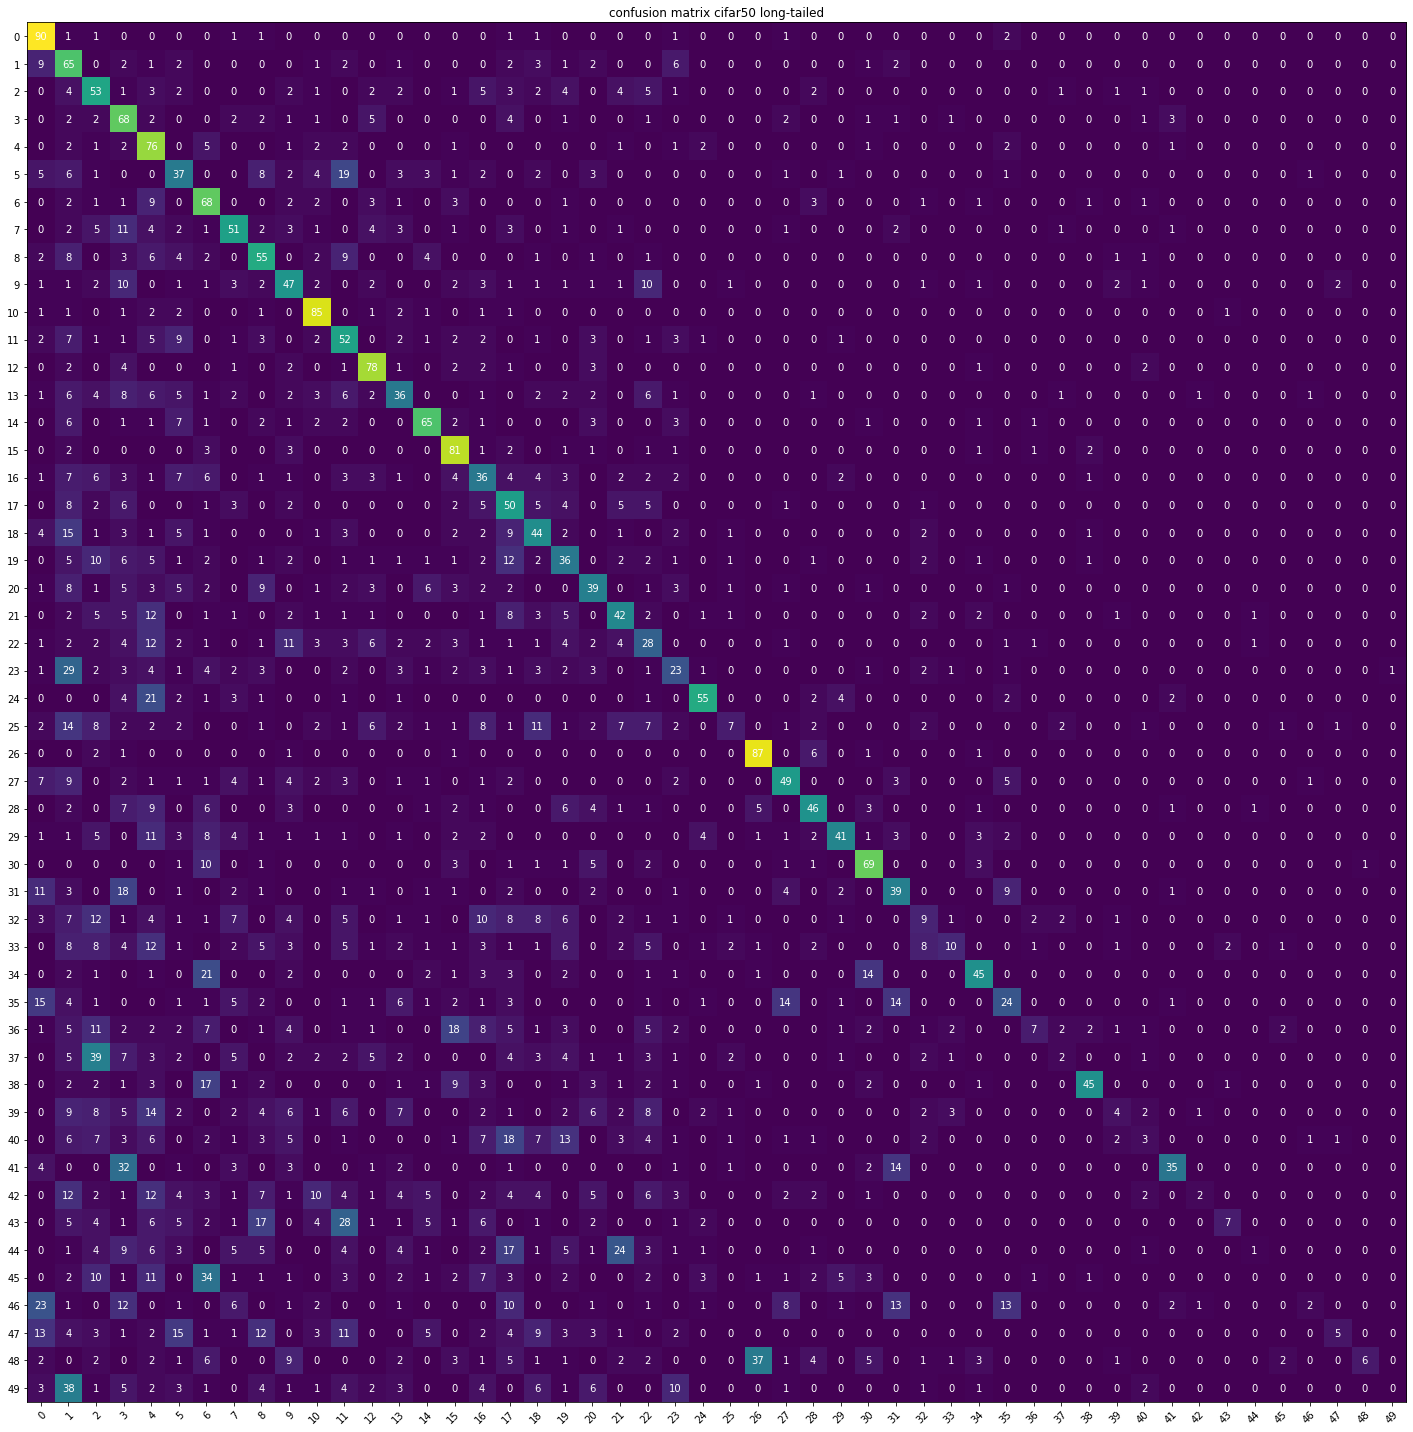

In [29]:
fig, ax = plt.subplots()
im = ax.imshow(confusion_matrix)

# We want to show all ticks...
ax.set_xticks(np.arange(50))
ax.set_yticks(np.arange(50))
# ... and label them with the respective list entries
#ax.set_xticklabels()
#ax.set_yticklabels()

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.

for i in range(50):
    for j in range(50):
        text = ax.text(j, i, int(confusion_matrix[i][j].item()),
                       ha="center", va="center", color="w")



ax.set_title("confusion matrix cifar50 long-tailed")
fig.set_size_inches(20,20)
fig.tight_layout()
plt.show()

Weighted sampler with data aug on dataset p = 0.02, accuracy_original_method = 32%

In [14]:
# data preparation

my_transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     transforms.RandomApply(torch.nn.ModuleList([transforms.RandomAffine(degrees=0, translate=(0.1, 0.1))]), p=0.3),
     transforms.RandomHorizontalFlip(p=0.3),
     transforms.RandomApply(torch.nn.ModuleList([transforms.RandomRotation(degrees=45)]), p=0.3),
     transforms.RandomApply(torch.nn.ModuleList([transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2)]), p=0.3)
    ])



cifar50_train_002 = CustomImageDataset(annotations_file="D:\cifar-100-data\cifar50\cifar50_imbalance_0.02\cifar50_imbalance_0.02_train.json", transform=my_transform)
#cifar50_train_flip = CustomImageDataset(annotations_file="/content/gdrive/MyDrive/cifar50/cifar50/cifar50_train.json", transform=flip_transform)
#cifar50_train_rotate = CustomImageDataset(annotations_file="/content/gdrive/MyDrive/cifar50/cifar50/cifar50_train.json", transform=rotate_transform)
#cifar50_train_shift = CustomImageDataset(annotations_file="/content/gdrive/MyDrive/cifar50/cifar50/cifar50_train.json", transform=shift_transform)
#cifar50_train_noise = CustomImageDataset(annotations_file="/content/gdrive/MyDrive/cifar50/cifar50/cifar50_train.json", transform=noise_transform)

cifar50_test = CustomImageDataset(annotations_file="D:\cifar-100-data\cifar50\cifar50_imbalance_0.02\cifar50_imbalance_0.02_test.json", transform=transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
     ]))



# long tailed function
u = 0.02
x = np.arange(start=1, stop=-0.01, step=-0.02)
n = 500 * (u**x)
class_weights = n[1:]
print(class_weights)
samp_weights = [0] * len(cifar50_train_002)
for idx in range(len(cifar50_train_002)):
    img, label = cifar50_train_002[idx]
    weight = class_weights[int(label)]
    samp_weights[idx] = weight
    
my_sampler = WeightedRandomSampler(samp_weights, num_samples=len(samp_weights), replacement=True)


train_loader_c50_LT002 = torch.utils.data.DataLoader(cifar50_train_002, batch_size=16, shuffle=False, drop_last=True, sampler=my_sampler)
test_loader_c50 = torch.utils.data.DataLoader(cifar50_test, batch_size=1, shuffle=False, drop_last=True)
print(len(train_loader_c50_LT002.dataset))

[ 10.81382657  11.6938845   12.64556389  13.67469348  14.78757637
  15.99102862  17.29242101  18.69972418  20.22155741  21.86724148
  23.64685569  25.57129963  27.65235993  29.90278245  32.33635033
  34.96796843  37.8137546   40.89113842  44.2189679   47.81762499
  51.70915035  55.91737839  60.4680832   65.38913647  70.71067812
  76.46530097  82.68825031  89.41763981  96.6946849  104.56395526
 113.07364774 122.27588161 132.22701772 142.98800372 154.62474736
 167.2085201  180.81639371 195.53171222 211.44460245 228.65252596
 247.26087601 267.38362302 289.14401265 312.6753206  338.1216689
 365.63890864 395.39557445 427.57391679 462.37101812 500.        ]


D:\conda\lib\site-packages\torchvision\transforms\functional_tensor.py:876: UserWarning: Argument fill/fillcolor is not supported for Tensor input. Fill value is zero
  warnings.warn("Argument fill/fillcolor is not supported for Tensor input. Fill value is zero")


6430


In [18]:
cnn, criterion, optimizer = prepare_cnn()

In [19]:
train_cnn("cifar50_LT002_weighted_sampler_data_aug", train_loader_c50_LT002, cifar50_train_002, start=1)

1 3.8834367743176212
2 3.8285156499171515
3 3.766594917926225
4 3.6621997524753884
5 3.571966537309472
Accuracy of test datasets: 13 %
6 3.485488157138854
7 3.403057578340474
8 3.3235511708593295
9 3.258497733535885
10 3.2041892293452476
Accuracy of test datasets: 21 %
11 3.11360233182299
12 3.0590794647833794
13 2.980171185815316
14 2.9160517186807065
15 2.826851805335441
Accuracy of test datasets: 25 %
16 2.7576325981650345
17 2.73631972880979
18 2.6664686372083604
19 2.638581438494693
20 2.5783544045028566
Accuracy of test datasets: 28 %
21 2.5261838607432128
22 2.4839411508610607
23 2.4262099223040496
24 2.3921593901899705
25 2.3337974744117465
Accuracy of test datasets: 32 %
26 2.2739844620320513
27 2.237711479578567
28 2.1537493060573265
29 2.1608015499441287
30 2.1148989601787846
Accuracy of test datasets: 34 %
31 2.0505515156415166
32 2.0249958803642594
33 1.9678990214275165
34 1.917151944411116
35 1.8953256964498137
Accuracy of test datasets: 34 %
36 1.8572484384243078
37 1.84

tensor([0.7300, 0.3400, 0.2400, 0.5200, 0.6100, 0.6000, 0.5000, 0.4100, 0.3300,
        0.5200, 0.7700, 0.3500, 0.7400, 0.2300, 0.6900, 0.7700, 0.1900, 0.3700,
        0.3800, 0.3000, 0.3100, 0.4500, 0.3600, 0.4000, 0.7300, 0.1000, 0.7200,
        0.4400, 0.6700, 0.4600, 0.8500, 0.4200, 0.1200, 0.1600, 0.6300, 0.3200,
        0.2000, 0.0800, 0.3600, 0.1500, 0.1600, 0.7700, 0.1000, 0.1800, 0.0200,
        0.0900, 0.1800, 0.5200, 0.1200, 0.0400])
f1 score = 0.3714444494422693


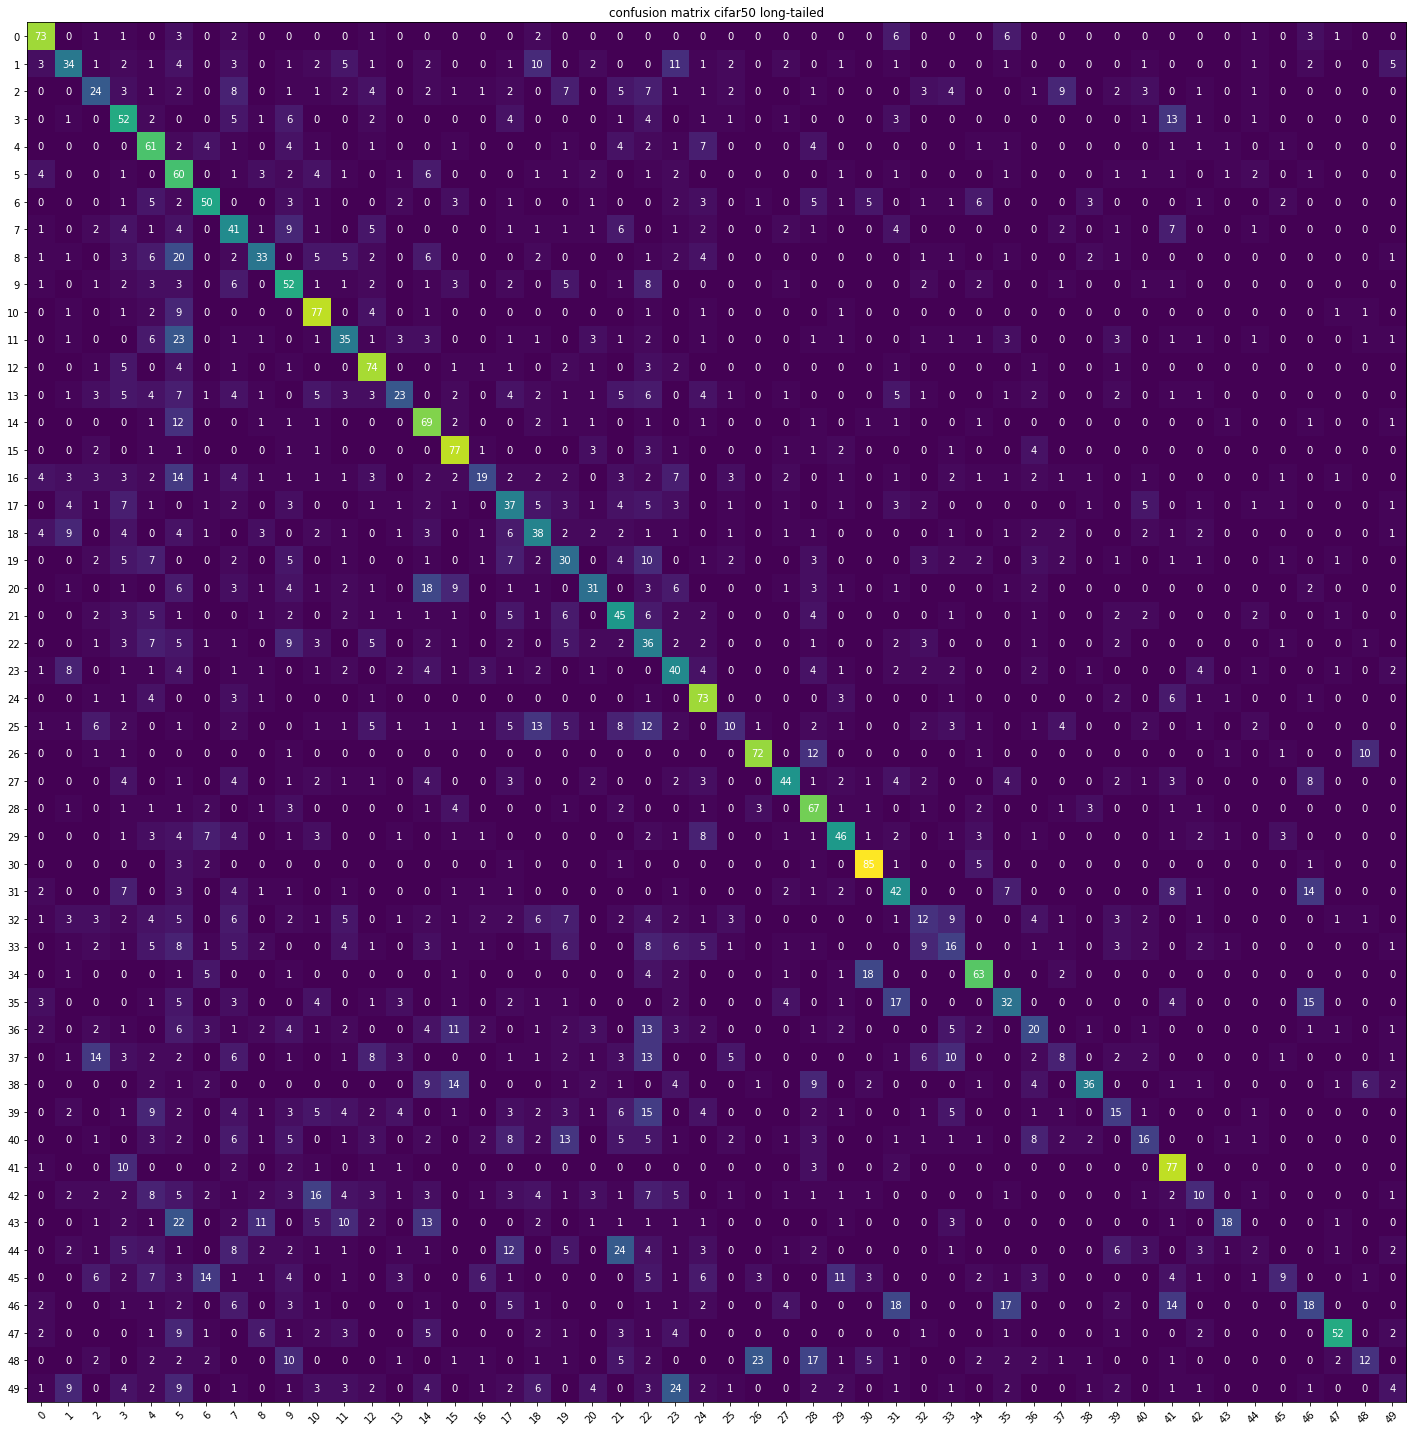

In [24]:
confusion_matrix = show_f1(50, "D:\cnn_models\cifar50_LT002_weighted_sampler_data_aug\cnn_cifar50_EPO_50.pth")
show_confusion_matrix(50, confusion_matrix)

weighted sampler with data augmentation on datatset p = 0.1， accuracy (w/o improvement) = 46%

In [52]:
# data preparation
# data preparation
test_transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     ])

my_transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     transforms.RandomApply(torch.nn.ModuleList([transforms.RandomAffine(degrees=0, translate=(0.1, 0.1))]), p=0.3),
     transforms.RandomHorizontalFlip(p=0.3),
     transforms.RandomApply(torch.nn.ModuleList([transforms.RandomRotation(degrees=45)]), p=0.3),
     transforms.RandomApply(torch.nn.ModuleList([transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2)]), p=0.3)
    ])

cifar50_train_01 = CustomImageDataset(annotations_file="D:\cifar-100-data\cifar50\cifar50_imbalance_0.1\cifar50_imbalance_0.1_train.json", transform=my_transform)
#cifar50_train_flip = CustomImageDataset(annotations_file="/content/gdrive/MyDrive/cifar50/cifar50/cifar50_train.json", transform=flip_transform)
#cifar50_train_rotate = CustomImageDataset(annotations_file="/content/gdrive/MyDrive/cifar50/cifar50/cifar50_train.json", transform=rotate_transform)
#cifar50_train_shift = CustomImageDataset(annotations_file="/content/gdrive/MyDrive/cifar50/cifar50/cifar50_train.json", transform=shift_transform)
#cifar50_train_noise = CustomImageDataset(annotations_file="/content/gdrive/MyDrive/cifar50/cifar50/cifar50_train.json", transform=noise_transform)

cifar50_test = CustomImageDataset(annotations_file="D:\cifar-100-data\cifar50\cifar50_imbalance_0.1\cifar50_imbalance_0.1_test.json", transform=test_transform)

# w = (n)/(n_j * n_classes)
# long tailed function

u = 0.1
x = np.arange(start=0, stop=51, step=1)
n = 500 * (u**(x/50))
n_samples_class = n[:50]
#print(class_weights)


n_samples = 9901
w = n_samples / (50 * n_samples_class)
print(w)

samp_weights = [0] * len(cifar50_train_01)
for idx in range(len(cifar50_train_01)):
     img, label = cifar50_train_01[idx]
     weight = w[int(label)]
     samp_weights[idx] = weight

    
my_sampler = WeightedRandomSampler(samp_weights, num_samples=len(samp_weights), replacement=True)





print("Print the length of training dataset:\n ", len(cifar50_train_01))
print("Print the testing dataset:\n ", len(cifar50_test))
#print(len(cifar50_train))
#cifar50_train.show_idx("annotations", 0, "fpath")

train_loader_c50_LT01 = torch.utils.data.DataLoader(cifar50_train_01, batch_size=16, shuffle=False, drop_last=True, sampler=my_sampler)
test_loader_c50 = torch.utils.data.DataLoader(cifar50_test, batch_size=1, shuffle=False, drop_last=True)


[0.39604    0.41470479 0.43424922 0.45471476 0.47614481 0.49858482
 0.5220824  0.54668738 0.57245197 0.5994308  0.6276811  0.6572628
 0.68823864 0.72067433 0.75463866 0.79020369 0.82744484 0.86644111
 0.90727523 0.95003379 0.9948075  1.04169134 1.09078474 1.14219184
 1.19602168 1.25238844 1.31141169 1.37321662 1.43793433 1.50570209
 1.57666364 1.65096951 1.7287773  1.81025207 1.89556662 1.98490192
 2.07844747 2.17640168 2.27897233 2.38637698 2.49884347 2.61661033
 2.73992738 2.86905618 3.00427063 3.14585754 3.29411724 3.4493642
 3.61192773 3.78215264]


D:\conda\lib\site-packages\torchvision\transforms\functional_tensor.py:876: UserWarning: Argument fill/fillcolor is not supported for Tensor input. Fill value is zero
  warnings.warn("Argument fill/fillcolor is not supported for Tensor input. Fill value is zero")


Print the length of training dataset:
  9901
Print the testing dataset:
  5000


In [53]:
cnn, critirion, optimizer = prepare_cnn()

In [56]:
train_cnn("cifar50_LT01_weighted_sampler_data_aug", train_loader_c50_LT01, cifar50_train_01, start=51)

D:\conda\lib\site-packages\torchvision\transforms\functional_tensor.py:876: UserWarning: Argument fill/fillcolor is not supported for Tensor input. Fill value is zero
  warnings.warn("Argument fill/fillcolor is not supported for Tensor input. Fill value is zero")


51 1.4967418602651663
52 1.4754812621839142
53 1.4460055293753682
54 1.4359424812795418
55 1.4516290906053302
Accuracy of test datasets: 49 %
56 1.3884805571056473
57 1.3751290812298285
58 1.3900485926837034
59 1.3364369716322575
60 1.3339185553865593
Accuracy of test datasets: 50 %
61 1.3316631246824335
62 1.3072829003310447
63 1.2810549707126646
64 1.2610784631680387
65 1.2526196656642736
Accuracy of test datasets: 50 %
66 1.2486039613331343
67 1.2340611053372788
68 1.2000416527010194
69 1.2092476153588032
70 1.1466919873750712
Accuracy of test datasets: 50 %
71 1.1771252200815632
72 1.1598205264439885
73 1.1648504128420958
74 1.1509206963240433
75 1.1282578545283242
Accuracy of test datasets: 50 %
76 1.0999364836049097
77 1.068017904691751
78 1.0839108280335612
79 1.0886359984869187
80 1.0565377286848017
Accuracy of test datasets: 50 %
81 1.0494287107198146
82 1.0283512842316855
83 1.0303970511640375
84 1.020649210730775
85 0.997424307718095
Accuracy of test datasets: 51 %
86 1.0104

In [ ]:
1 3.8793796511951473
2 3.7921718508411497
3 3.6572396136115217
4 3.5229650288805217
5 3.40430912934413
Accuracy of test datasets: 17 %
6 3.30375024109534
7 3.212863387730179
8 3.135065534333727
9 3.0573905657402327
10 2.9662605600036307
Accuracy of test datasets: 25 %
11 2.9119221539271503
12 2.8661524933789093
13 2.799645093219134
14 2.73386470862873
15 2.7026610527119486
Accuracy of test datasets: 31 %
16 2.6530316935297384
17 2.6027855335155072
18 2.544603137027951
19 2.5105299503198117
20 2.4636084500039157
Accuracy of test datasets: 35 %
21 2.4381246521501585
22 2.376086688044095
23 2.3552506353118035
24 2.303138677043971
25 2.2567205272073902
Accuracy of test datasets: 39 %
26 2.2198498861414775
27 2.1716831505099954
28 2.1745908315489237
29 2.1312068157660313
30 2.0936036255850645
Accuracy of test datasets: 43 %
31 2.017730183125072
32 1.9937843523679533
33 1.9558198596718166
34 1.9585201214111378
35 1.9036986292546332
Accuracy of test datasets: 45 %
36 1.8936085020480837
37 1.8302290168702873
38 1.8245526465872612
39 1.7763486810554556
40 1.7727019622366593
Accuracy of test datasets: 46 %
41 1.7295785141453552
42 1.721517033582263
43 1.6841692250734048
44 1.6778197826466021
45 1.6374211975473694
Accuracy of test datasets: 47 %
46 1.626502647530899
47 1.601912167611453
48 1.5749408740032178
49 1.5376052803468758
50 1.5124616304102263
Accuracy of test datasets: 48 %
Finished Training
[54.54055775022044, 47.522566026854285, 43.29942893673301, 39.469558678784416, 36.15499990271905, 33.541698215077226, 30.499223508495344, 28.400521242888615, 26.233183295981398, 24.231201622478398]
[17.86, 25.4, 31.04, 35.62, 39.88, 43.06, 45.52, 46.2, 47.52, 48.08]

tensor([0.8400, 0.4500, 0.5600, 0.6700, 0.7300, 0.5500, 0.7000, 0.5400, 0.5600,
        0.6100, 0.8300, 0.5600, 0.8400, 0.4700, 0.6500, 0.7800, 0.4900, 0.6000,
        0.5000, 0.4300, 0.4400, 0.4000, 0.3800, 0.3200, 0.7500, 0.2500, 0.8700,
        0.6200, 0.6800, 0.7700, 0.8000, 0.6800, 0.2400, 0.3400, 0.7000, 0.2900,
        0.2000, 0.2100, 0.8000, 0.1800, 0.1000, 0.7400, 0.3000, 0.3100, 0.3600,
        0.3500, 0.2700, 0.6200, 0.3500, 0.1000])
f1 score = 0.5028834098090664


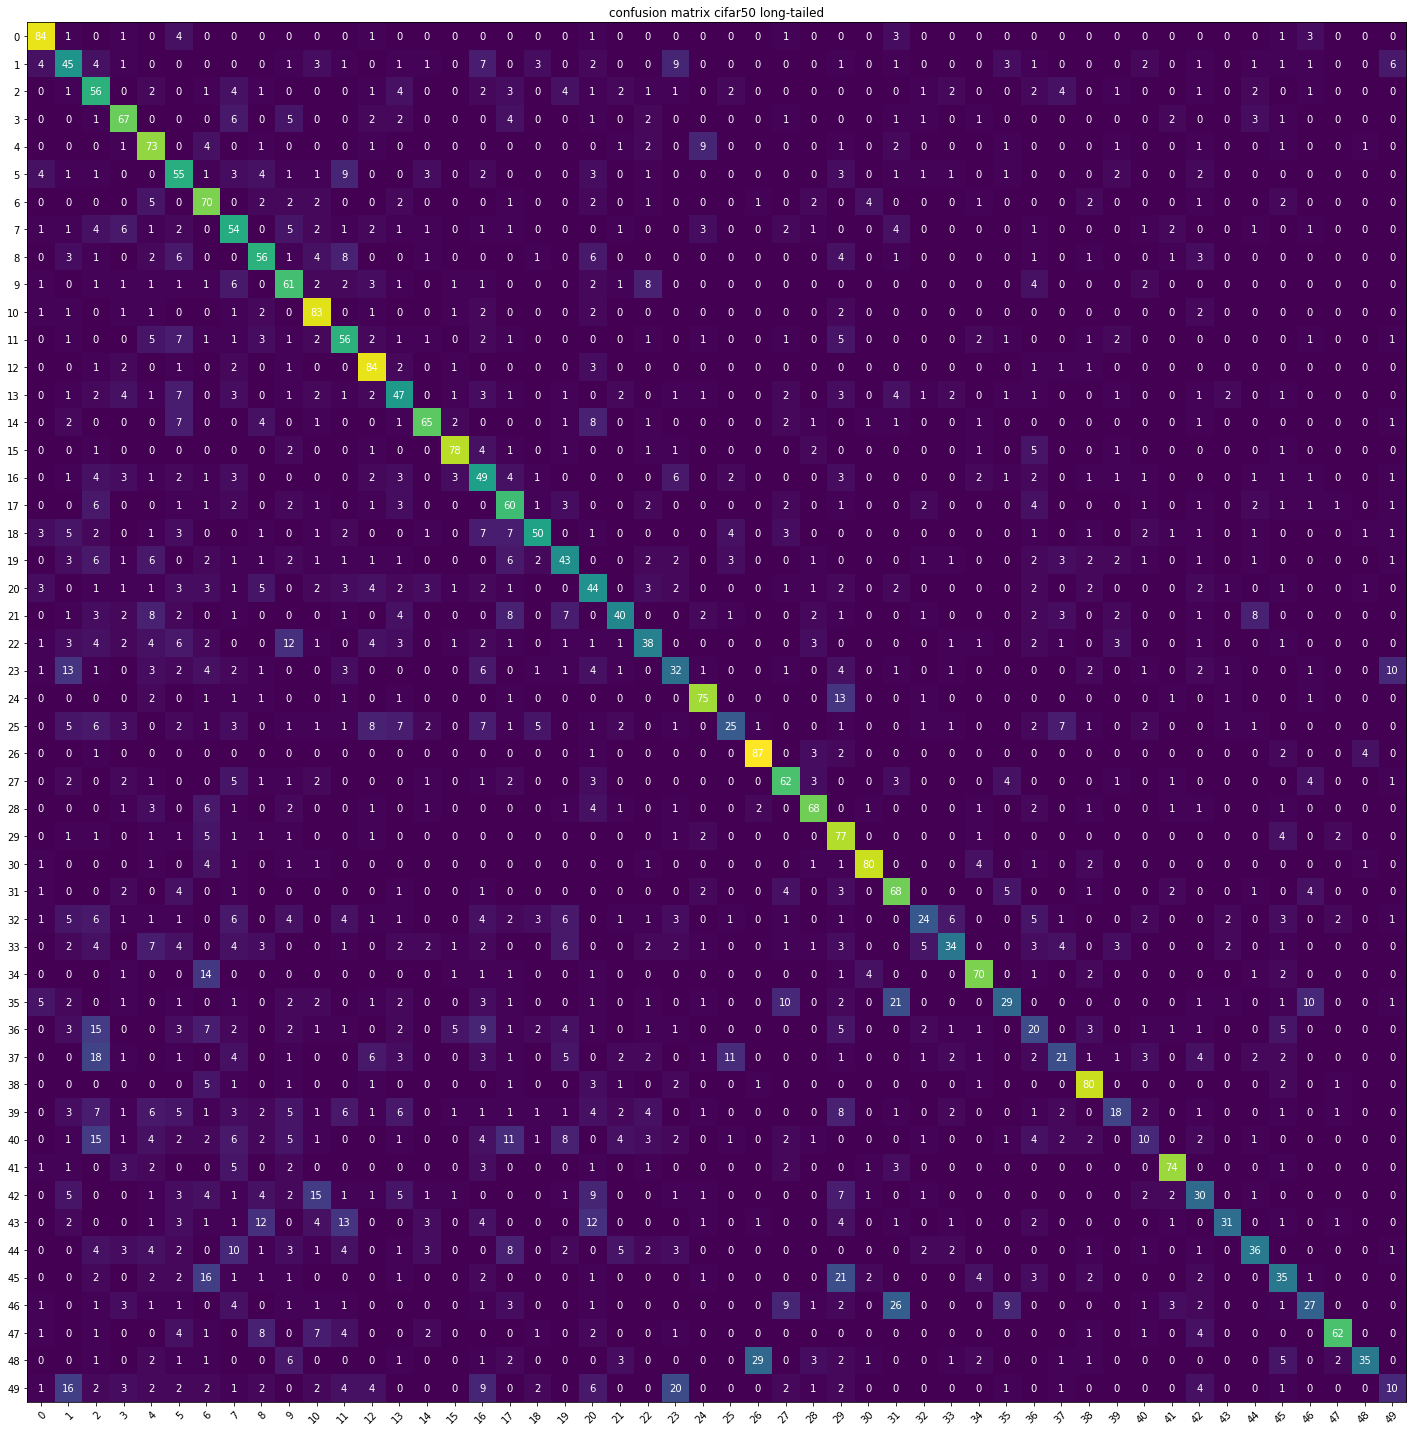

In [57]:
confusion_matrix = show_f1(50, "D:\cnn_models\cifar50_LT01_weighted_sampler_data_aug\cnn_cifar50_EPO_100.pth")
show_confusion_matrix(50, confusion_matrix)

# try this method on breast cancer imbalanced dataset
# 0 for benign, 1 for malignant

In [76]:
from torchvision.datasets import ImageFolder
import torch
from torchvision import transforms


normalize=transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
transform=transforms.Compose([
    transforms.ToTensor(),
    normalize
])

dataset_cancer = ImageFolder('D:/cancer_dataset/train/',transform=transform)
testset_cancer = ImageFolder('D:/cancer_dataset/test/',transform=transform)


cancer_loader_train = torch.utils.data.DataLoader(dataset_cancer, batch_size=16, shuffle=True, drop_last=True)
cancer_loader_test = torch.utils.data.DataLoader(testset_cancer, batch_size=1, shuffle=False, drop_last=True)
print(len(cancer_loader_train.dataset))

848


In [77]:
##

class CNNCifar_2(nn.Module):
    def __init__(self):
        super(CNNCifar_2,self).__init__()
        self.feature = nn.Sequential(
            nn.Conv2d(3,32,3,padding=2),   nn.BatchNorm2d(32),  nn.ReLU(), nn.MaxPool2d(2,2), # (50-3+4+1)/2 = 26
            nn.Conv2d(32,64,3,padding=2), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2,2), # (26-3+4+1)/2 = 14
            nn.Conv2d(64,128,3,padding=1),nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2,2), # (14-3+2+1)/2 = 7
            nn.Conv2d(128,256,3,padding=1),nn.BatchNorm2d(256), nn.ReLU(), nn.MaxPool2d(2,2)  # (7-3+2+1)/2 = 3.5
        )
        self.classifier=nn.Sequential(
            nn.Flatten(),
            nn.Linear(2304, 4096),nn.ReLU(),
            nn.Linear(4096,4096), nn.ReLU(),
            nn.Linear(4096,2)
        )
        
    def forward(self, x):
 
        x = self.feature(x)
        output = self.classifier(x)
        return output
        
cnn = CNNCifar().to(device)
print(cnn)

CNNCifar(
  (feature): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True

In [78]:
cnn2 = CNNCifar_2().to(device)
criterion = nn.CrossEntropyLoss() 
optimizer = optim.SGD(cnn2.parameters(), lr=0.0001, momentum=0.9)


In [79]:
n_epoch = 50
accuracy_list = []
loss_list = []
PATH_PER_10EPOCH = "D:\cnn_models\cancer_detect"

for epoch in range(n_epoch):  # loop over the dataset multiple times
  epoch_loss = 0.0
  running_loss = 0.0
  cnn2.train()
  for i, data in enumerate(cancer_loader_train):
    # TODO: write training code
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    #print("epoch:", epoch, "i:", i)
    # print("labels:", type(labels.to(device)))
    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = cnn2(inputs.to(device))
    loss = criterion(outputs, labels.to(device).long())
    loss.backward()
    optimizer.step()
    

    epoch_loss += outputs.shape[0] * loss.item()

    # print statistics
    #running_loss += loss.item()
    #if i % 2000 == 1999:    # print every 2000 mini-batches
     #   print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
      #  running_loss = 0.0

    # print epoch loss
  print(epoch+1, epoch_loss / len(cancer_loader_train))
  # (epoch+1) % 10 == 0
  if ((epoch+1) % 5 == 0):
    ## store state dict
    torch.save(cnn2.state_dict(), PATH_PER_10EPOCH + '\cancer_cnn' + '_EPO_' + str(epoch + 1) + '.pth')
    loss_list.append(epoch_loss / len(cancer_loader_train))
    
    # test accuracy
    total = 0
    correct = 0
    with torch.no_grad():
        cnn2.eval()
        for data_test in cancer_loader_test:
            images_test, labels_test = data_test[0].float().to(device), data_test[1].to(device).long()
            outputs_test = cnn2(images_test)
            _, predicted = torch.max(outputs_test.data, 1)
            total += labels_test.size(0)
            correct += (predicted == labels_test).sum().item()

    print('Accuracy of test datasets: %d %%' % (
        100 * correct / total))
    # store accuracy
    accuracy_list.append(100 * correct / total)

print('Finished Training')
print(loss_list)
print(accuracy_list)
#PATH = '/content/gdrive/MyDrive/EE 443/cnn_cifar50.pth'
#torch.save(cnn.state_dict(), PATH)


1 5.356204961830715
2 3.415911428208621
3 2.7779193745469146
4 2.3926932946690975
5 2.164251333137728
Accuracy of test datasets: 67 %
6 2.007800999677406
7 1.9136108834788483
8 1.8693122571369387
9 1.7303742800118789
10 1.777223234469036
Accuracy of test datasets: 69 %
11 1.6945007943882133
12 1.5915025939356606
13 1.5710221737060908
14 1.534577487212307
15 1.5073430802462235
Accuracy of test datasets: 68 %
16 1.4278621859145615
17 1.419960490094041
18 1.361416813056424
19 1.437131203570456
20 1.353369634949936
Accuracy of test datasets: 68 %
21 1.3272273045665812
22 1.2795575047438998
23 1.3099176605355065
24 1.2306819223570373
25 1.2352329723115236
Accuracy of test datasets: 64 %
26 1.171178769390538
27 1.1575501074768462
28 1.1733415149292856
29 1.0701462792338066
30 1.1143611908521291
Accuracy of test datasets: 65 %
31 1.109793114212324
32 1.067416640666296
33 1.034195234190743
34 1.0473385163635578
35 1.0468107346656188
Accuracy of test datasets: 63 %
36 1.0137258784950904
37 1.00

In [84]:
from sklearn.metrics import f1_score
# accuracy for each class
nb_classes = 2
cnn2 = CNNCifar_2().to(device)
cnn2.load_state_dict(torch.load('D:\cnn_models\cancer_detect\cancer_cnn_EPO_10.pth'))
confusion_matrix = torch.zeros(nb_classes, nb_classes)
y_preds = []
y_true = []
with torch.no_grad():
    cnn2.eval()
    for data in cancer_loader_test:
        inputs, classes = data[0].float().to(device), data[1].to(device).long()
        outputs = cnn2(inputs)
        #print(outputs.shape)
        _, preds = torch.max(outputs, 1)
        y_preds.append(preds.item())
        y_true.append(classes.item())
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix.diag()/confusion_matrix.sum(1))

f1 = f1_score(y_true, y_preds, average='macro')
print("f1 score =", f1)

tensor([0.9931, 0.4000])
f1 score = 0.6672924488944514


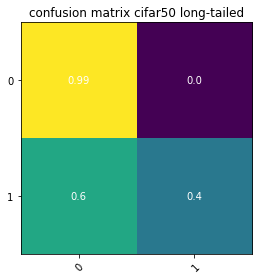

In [85]:
fig, ax = plt.subplots()
im = ax.imshow(confusion_matrix)

# We want to show all ticks...
ax.set_xticks(np.arange(2))
ax.set_yticks(np.arange(2))
# ... and label them with the respective list entries
#ax.set_xticklabels()
#ax.set_yticklabels()

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.

for i in range(2):
    for j in range(2):
        text = ax.text(j, i, int(int(confusion_matrix[i][j].item())/145 * 100)/100,
                       ha="center", va="center", color="w")



ax.set_title("confusion matrix cifar50 long-tailed")
fig.tight_layout()
plt.show()

# use weighted random sampler combined with data aug

In [87]:
# data preparation

my_transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     transforms.RandomApply(torch.nn.ModuleList([transforms.RandomAffine(degrees=0, translate=(0.1, 0.1))]), p=0.3),
     transforms.RandomHorizontalFlip(p=0.3),
     transforms.RandomApply(torch.nn.ModuleList([transforms.RandomRotation(degrees=45)]), p=0.3),
     transforms.RandomApply(torch.nn.ModuleList([transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2)]), p=0.3)
    ])



dataset_cancer = ImageFolder('D:/cancer_dataset/train/',transform=my_transform)
testset_cancer = ImageFolder('D:/cancer_dataset/test/',transform=transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))


# w = (n)/(n_j * n_classes)
# long tailed function

n_samples_class = [772, 76]
#print(class_weights)


n_samples = 848
w = [76, 772]

samp_weights = [0] * len(dataset_cancer)
for idx in range(len(dataset_cancer)):
     img, label = dataset_cancer[idx]
     weight = w[int(label)]
     samp_weights[idx] = weight

    
my_sampler = WeightedRandomSampler(samp_weights, num_samples=len(samp_weights), replacement=True)


cancer_loader_train = torch.utils.data.DataLoader(dataset_cancer, batch_size=16, shuffle=False, drop_last=True, sampler=my_sampler)
cancer_loader_test = torch.utils.data.DataLoader(testset_cancer, batch_size=1, shuffle=False, drop_last=True)
print(len(cancer_loader_train.dataset))

848


In [88]:
cnn2 = CNNCifar_2().to(device)
criterion = nn.CrossEntropyLoss() 
optimizer = optim.SGD(cnn2.parameters(), lr=0.0001, momentum=0.9)

In [89]:
n_epoch = 50
accuracy_list = []
loss_list = []
PATH_PER_10EPOCH = "D:\cnn_models\cancer_detect_weighted_sampler"

for epoch in range(n_epoch):  # loop over the dataset multiple times
  epoch_loss = 0.0
  running_loss = 0.0
  cnn2.train()
  for i, data in enumerate(cancer_loader_train):
    # TODO: write training code
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    #print("epoch:", epoch, "i:", i)
    # print("labels:", type(labels.to(device)))
    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = cnn2(inputs.to(device))
    loss = criterion(outputs, labels.to(device).long())
    loss.backward()
    optimizer.step()
    

    epoch_loss += outputs.shape[0] * loss.item()

    # print statistics
    #running_loss += loss.item()
    #if i % 2000 == 1999:    # print every 2000 mini-batches
     #   print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
      #  running_loss = 0.0

    # print epoch loss
  print(epoch+1, epoch_loss / len(cancer_loader_train))
  # (epoch+1) % 10 == 0
  if ((epoch+1) % 5 == 0):
    ## store state dict
    torch.save(cnn2.state_dict(), PATH_PER_10EPOCH + '\cancer_cnn' + '_EPO_' + str(epoch + 1) + '.pth')
    loss_list.append(epoch_loss / len(cancer_loader_train))
    
    # test accuracy
    total = 0
    correct = 0
    with torch.no_grad():
        cnn2.eval()
        for data_test in cancer_loader_test:
            images_test, labels_test = data_test[0].float().to(device), data_test[1].to(device).long()
            outputs_test = cnn2(images_test)
            _, predicted = torch.max(outputs_test.data, 1)
            total += labels_test.size(0)
            correct += (predicted == labels_test).sum().item()

    print('Accuracy of test datasets: %d %%' % (
        100 * correct / total))
    # store accuracy
    accuracy_list.append(100 * correct / total)

print('Finished Training')
print(loss_list)
print(accuracy_list)
#PATH = '/content/gdrive/MyDrive/EE 443/cnn_cifar50.pth'
#torch.save(cnn.state_dict(), PATH)

1 9.383960489956838
2 6.4680360263248655
3 4.9343817548931765
4 4.977102725010998
5 4.770175313049892
Accuracy of test datasets: 73 %
6 4.086244785560752
7 4.426406052877319
8 3.9672878519544064
9 4.3588773012161255
10 3.9916205068804183
Accuracy of test datasets: 74 %
11 4.812564199825503
12 3.920842984937272
13 3.454926738199198
14 4.505244047011969
15 3.9898569482677386
Accuracy of test datasets: 73 %
16 4.247317381624906
17 4.519268372148837
18 3.9627640922114535
19 3.468554034547986
20 3.9362026329310433
Accuracy of test datasets: 72 %
21 3.6057981455101156
22 3.753837654050791
23 3.9604461350530946
24 3.7413616990143397
25 3.2114991511938706
Accuracy of test datasets: 70 %
26 3.4920566396893196
27 3.3838130629287577
28 3.2813254167448798
29 2.939291281520196
30 3.2655717887968385
Accuracy of test datasets: 68 %
31 3.276579021282916
32 3.404426546591633
33 3.427951698033315
34 3.057902457579127
35 2.741462097977692
Accuracy of test datasets: 67 %
36 3.471846473666857
37 3.32416855

In [90]:
from sklearn.metrics import f1_score
# accuracy for each class
nb_classes = 2
cnn2 = CNNCifar_2().to(device)
cnn2.load_state_dict(torch.load('D:\cnn_models\cancer_detect_weighted_sampler\cancer_cnn_EPO_10.pth'))
confusion_matrix = torch.zeros(nb_classes, nb_classes)
y_preds = []
y_true = []
with torch.no_grad():
    cnn2.eval()
    for data in cancer_loader_test:
        inputs, classes = data[0].float().to(device), data[1].to(device).long()
        outputs = cnn2(inputs)
        #print(outputs.shape)
        _, preds = torch.max(outputs, 1)
        y_preds.append(preds.item())
        y_true.append(classes.item())
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix.diag()/confusion_matrix.sum(1))

f1 = f1_score(y_true, y_preds, average='macro')
print("f1 score =", f1)

tensor([0.9034, 0.5862])
f1 score = 0.7382416081186572


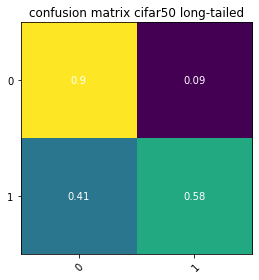

In [91]:
fig, ax = plt.subplots()
im = ax.imshow(confusion_matrix)

# We want to show all ticks...
ax.set_xticks(np.arange(2))
ax.set_yticks(np.arange(2))
# ... and label them with the respective list entries
#ax.set_xticklabels()
#ax.set_yticklabels()

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.

for i in range(2):
    for j in range(2):
        text = ax.text(j, i, int(int(confusion_matrix[i][j].item())/145 * 100)/100,
                       ha="center", va="center", color="w")



ax.set_title("confusion matrix cifar50 long-tailed")
fig.tight_layout()
plt.show()

crossentropy Weights

In [14]:
# data preparation

my_transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     transforms.RandomApply(torch.nn.ModuleList([transforms.RandomAffine(degrees=0, translate=(0.1, 0.1))]), p=0.3),
     transforms.RandomHorizontalFlip(p=0.3),
     transforms.RandomApply(torch.nn.ModuleList([transforms.RandomRotation(degrees=45)]), p=0.3),
     transforms.RandomApply(torch.nn.ModuleList([transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2)]), p=0.3)
    ])



dataset_cancer = ImageFolder('D:/cancer_dataset/train/',transform=my_transform)
testset_cancer = ImageFolder('D:/cancer_dataset/test/',transform=transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))


# w = (n)/(n_j * n_classes)
# long tailed function

n_samples_class = [772, 76]
#print(class_weights)


n_samples = 848
w = [76, 772]

# samp_weights = [0] * len(dataset_cancer)
# for idx in range(len(dataset_cancer)):
#      img, label = dataset_cancer[idx]
#      weight = w[int(label)]
#      samp_weights[idx] = weight

    
# my_sampler = WeightedRandomSampler(samp_weights, num_samples=len(samp_weights), replacement=True)


cancer_loader_train = torch.utils.data.DataLoader(dataset_cancer, batch_size=16, shuffle=True, drop_last=True)
cancer_loader_test = torch.utils.data.DataLoader(testset_cancer, batch_size=1, shuffle=False, drop_last=True)
print(len(cancer_loader_train.dataset))

848


In [16]:
cnn2 = CNNCifar_2().to(device)
criterion = nn.CrossEntropyLoss(weight=torch.Tensor([0.23, 0.9]).to(device))
optimizer = optim.SGD(cnn2.parameters(), lr=0.0001, momentum=0.9)

In [17]:
n_epoch = 20
accuracy_list = []
loss_list = []
PATH_PER_10EPOCH = "D:\cnn_models\cancer_detect_weighted_loss"

for epoch in range(n_epoch):  # loop over the dataset multiple times
  epoch_loss = 0.0
  running_loss = 0.0
  cnn2.train()
  for i, data in enumerate(cancer_loader_train):
    # TODO: write training code
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    #print("epoch:", epoch, "i:", i)
    # print("labels:", type(labels.to(device)))
    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = cnn2(inputs.to(device))
    loss = criterion(outputs, labels.to(device).long())
    loss.backward()
    optimizer.step()
    

    epoch_loss += outputs.shape[0] * loss.item()

    # print statistics
    #running_loss += loss.item()
    #if i % 2000 == 1999:    # print every 2000 mini-batches
     #   print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
      #  running_loss = 0.0

    # print epoch loss
  print(epoch+1, epoch_loss / len(cancer_loader_train))
  # (epoch+1) % 10 == 0
  if ((epoch+1) % 5 == 0):
    ## store state dict
    torch.save(cnn2.state_dict(), PATH_PER_10EPOCH + '\cancer_cnn' + '_EPO_' + str(epoch + 1) + '.pth')
    loss_list.append(epoch_loss / len(cancer_loader_train))
    
    # test accuracy
    total = 0
    correct = 0
    with torch.no_grad():
        cnn2.eval()
        for data_test in cancer_loader_test:
            images_test, labels_test = data_test[0].float().to(device), data_test[1].to(device).long()
            outputs_test = cnn2(images_test)
            _, predicted = torch.max(outputs_test.data, 1)
            total += labels_test.size(0)
            correct += (predicted == labels_test).sum().item()

    print('Accuracy of test datasets: %d %%' % (
        100 * correct / total))
    # store accuracy
    accuracy_list.append(100 * correct / total)

print('Finished Training')
print(loss_list)
print(accuracy_list)
#PATH = '/content/gdrive/MyDrive/EE 443/cnn_cifar50.pth'
#torch.save(cnn.state_dict(), PATH)

D:\conda\lib\site-packages\torchvision\transforms\functional_tensor.py:876: UserWarning: Argument fill/fillcolor is not supported for Tensor input. Fill value is zero
  warnings.warn("Argument fill/fillcolor is not supported for Tensor input. Fill value is zero")


1 7.910672016863553
2 5.280079877601479
3 4.401614094680211
4 3.9382692328039206
5 3.812760058439003
Accuracy of test datasets: 73 %
6 3.7123902676240452
7 3.7439027203703827
8 3.4531069847772704
9 3.762505587541832
10 3.3349017174738758
Accuracy of test datasets: 73 %
11 3.4935228161092073
12 3.3737383833471335
13 3.451084503587687
14 3.200836516776175
15 3.2911070101666002
Accuracy of test datasets: 72 %
16 3.2954250866512083
17 3.1848956683896623
18 3.3107461996798246
19 3.303366463139372
20 3.215241772948571
Accuracy of test datasets: 73 %
Finished Training
[3.812760058439003, 3.3349017174738758, 3.2911070101666002, 3.215241772948571]
[73.79310344827586, 73.10344827586206, 72.41379310344827, 73.44827586206897]


In [18]:
from sklearn.metrics import f1_score
# accuracy for each class
nb_classes = 2
cnn2 = CNNCifar_2().to(device)
cnn2.load_state_dict(torch.load('D:\cnn_models\cancer_detect_weighted_loss\cancer_cnn_EPO_10.pth'))
confusion_matrix = torch.zeros(nb_classes, nb_classes)
y_preds = []
y_true = []
with torch.no_grad():
    cnn2.eval()
    for data in cancer_loader_test:
        inputs, classes = data[0].float().to(device), data[1].to(device).long()
        outputs = cnn2(inputs)
        #print(outputs.shape)
        _, preds = torch.max(outputs, 1)
        y_preds.append(preds.item())
        y_true.append(classes.item())
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix.diag()/confusion_matrix.sum(1))

f1 = f1_score(y_true, y_preds, average='macro')
print("f1 score =", f1)

tensor([0.9379, 0.5241])
f1 score = 0.7190062111801243


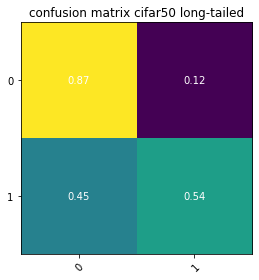

In [52]:
fig, ax = plt.subplots()
im = ax.imshow(confusion_matrix)

# We want to show all ticks...
ax.set_xticks(np.arange(2))
ax.set_yticks(np.arange(2))
# ... and label them with the respective list entries
#ax.set_xticklabels()
#ax.set_yticklabels()

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.

for i in range(2):
    for j in range(2):
        text = ax.text(j, i, int(int(confusion_matrix[i][j].item())/145 * 100)/100,
                       ha="center", va="center", color="w")



ax.set_title("confusion matrix cifar50 long-tailed")
fig.tight_layout()
plt.show()